In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/NEUROCIRUGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=124.5, y1=102.1
Page 1, Q1, A: Yellow pixels: 509
Page 1, Q1, A: Total non-white pixels: 756
Page 1, Q1, A: Yellow percentage: 67.3%


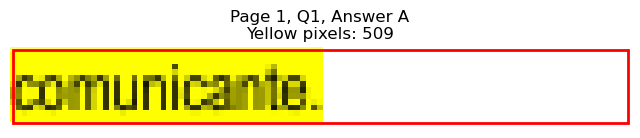

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=116.9, y1=114.7
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 280
Page 1, Q1, B: Yellow percentage: 0.0%


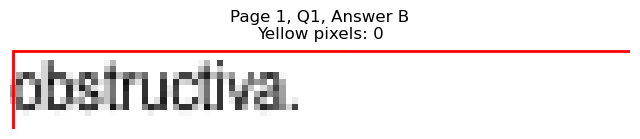

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=366.2, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 173
Page 1, Q1, C: Yellow percentage: 0.0%


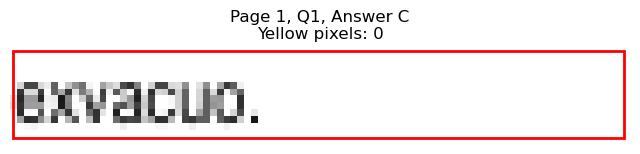

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=374.7, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 242
Page 1, Q1, D: Yellow percentage: 0.0%


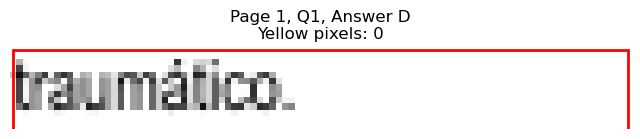


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=120.5, y1=152.6
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 262
Page 1, Q2, A: Yellow percentage: 0.0%


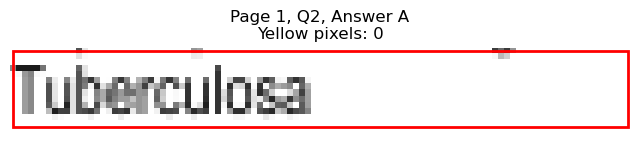

Page 1, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=131.5, y1=165.2
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 340
Page 1, Q2, B: Yellow percentage: 0.0%


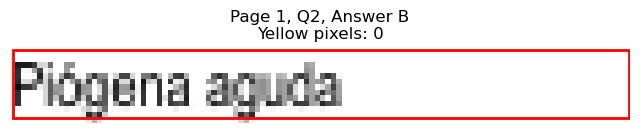

Page 1, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=375.7, y1=152.6
Page 1, Q2, C: Yellow pixels: 1104
Page 1, Q2, C: Total non-white pixels: 1386
Page 1, Q2, C: Yellow percentage: 79.7%


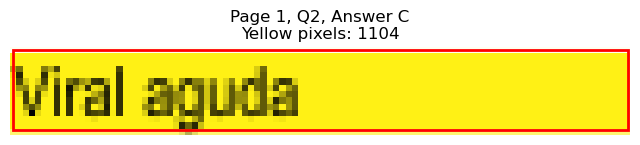

Page 1, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=389.2, y1=165.2
Page 1, Q2, D: Yellow pixels: 112
Page 1, Q2, D: Total non-white pixels: 436
Page 1, Q2, D: Yellow percentage: 25.7%


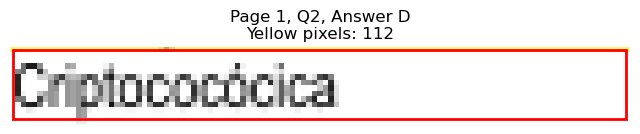


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=137.5, y1=240.9
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 378
Page 1, Q3, A: Yellow percentage: 0.0%


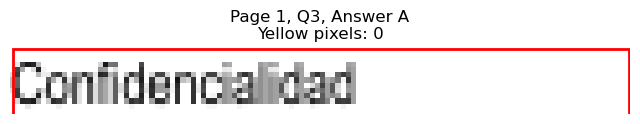

Page 1, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=135.0, y1=253.5
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 336
Page 1, Q3, B: Yellow percentage: 0.0%


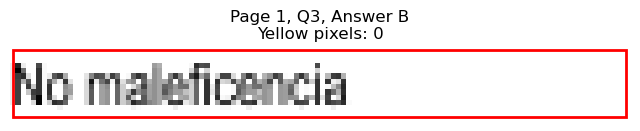

Page 1, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=373.7, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 321
Page 1, Q3, C: Yellow percentage: 0.0%


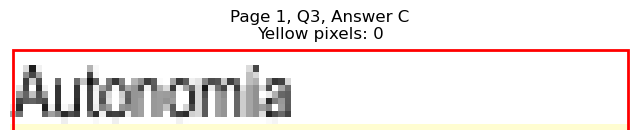

Page 1, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=360.2, y1=253.5
Page 1, Q3, D: Yellow pixels: 957
Page 1, Q3, D: Total non-white pixels: 1176
Page 1, Q3, D: Yellow percentage: 81.4%


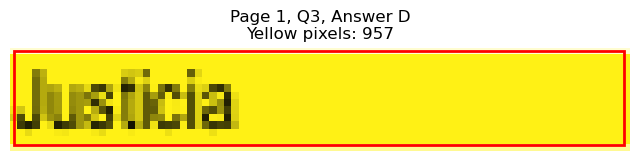


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=130.9, y1=291.5
Page 1, Q4, A: Yellow pixels: 113
Page 1, Q4, A: Total non-white pixels: 443
Page 1, Q4, A: Yellow percentage: 25.5%


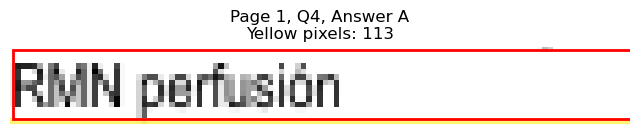

Page 1, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=136.5, y1=304.1
Page 1, Q4, B: Yellow pixels: 1303
Page 1, Q4, B: Total non-white pixels: 1666
Page 1, Q4, B: Yellow percentage: 78.2%


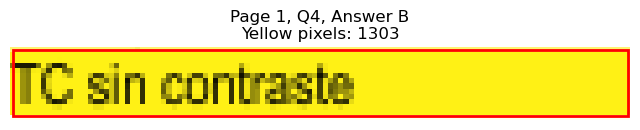

Page 1, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=376.3, y1=291.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 247
Page 1, Q4, C: Yellow percentage: 0.0%


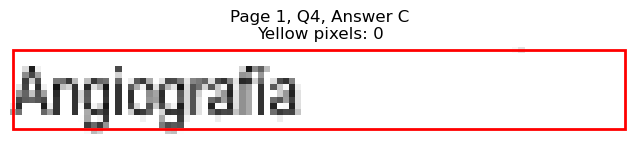

Page 1, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=392.2, y1=304.1
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 339
Page 1, Q4, D: Yellow percentage: 0.0%


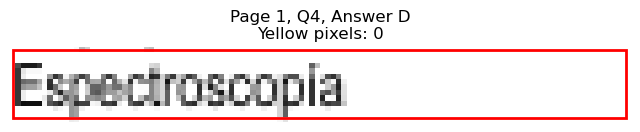


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=135.0, y1=367.2
Page 1, Q5, A: Yellow pixels: 118
Page 1, Q5, A: Total non-white pixels: 457
Page 1, Q5, A: Yellow percentage: 25.8%


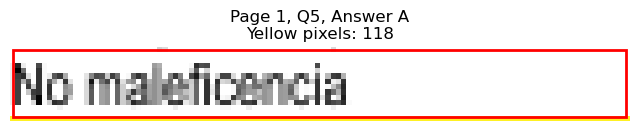

Page 1, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=114.5, y1=379.8
Page 1, Q5, B: Yellow pixels: 1072
Page 1, Q5, B: Total non-white pixels: 1261
Page 1, Q5, B: Yellow percentage: 85.0%


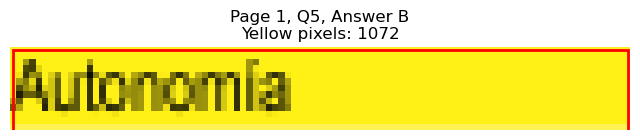

Page 1, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=360.2, y1=367.2
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 175
Page 1, Q5, C: Yellow percentage: 0.0%


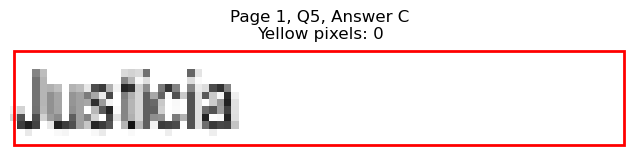

Page 1, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=381.7, y1=379.8
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 284
Page 1, Q5, D: Yellow percentage: 0.0%


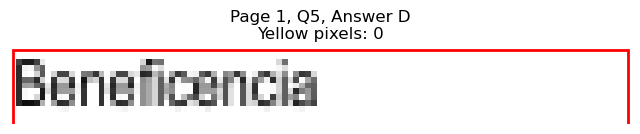


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=366.2, y1=430.3
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 1483
Page 1, Q6, A: Yellow percentage: 0.0%


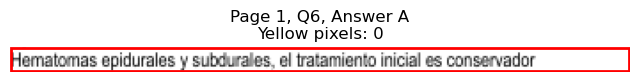

Page 1, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=454.1, y1=442.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 1821
Page 1, Q6, B: Yellow percentage: 0.0%


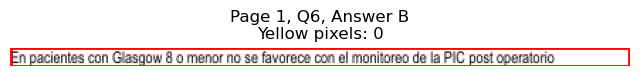

Page 1, Q6 - C: Detected box: x0=68.8, y0=442.8, x1=401.2, y1=455.5
Page 1, Q6, C: Yellow pixels: 384
Page 1, Q6, C: Total non-white pixels: 2033
Page 1, Q6, C: Yellow percentage: 18.9%


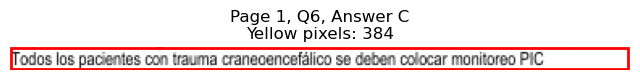

Page 1, Q6 - D: Detected box: x0=68.8, y0=455.5, x1=307.0, y1=468.1
Page 1, Q6, D: Yellow pixels: 2921
Page 1, Q6, D: Total non-white pixels: 4060
Page 1, Q6, D: Yellow percentage: 71.9%


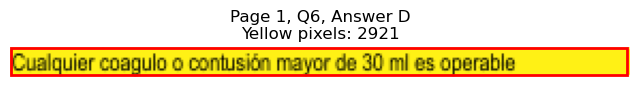


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=164.1, y1=506.0
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 491
Page 1, Q7, A: Yellow percentage: 0.0%


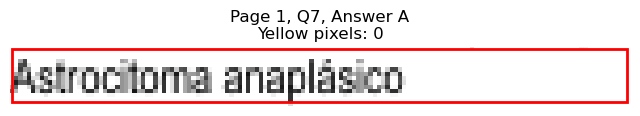

Page 1, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=168.1, y1=518.6
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 510
Page 1, Q7, B: Yellow percentage: 0.0%


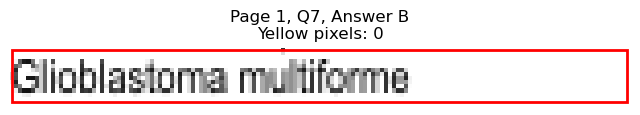

Page 1, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=383.2, y1=506.0
Page 1, Q7, C: Yellow pixels: 107
Page 1, Q7, C: Total non-white pixels: 488
Page 1, Q7, C: Yellow percentage: 21.9%


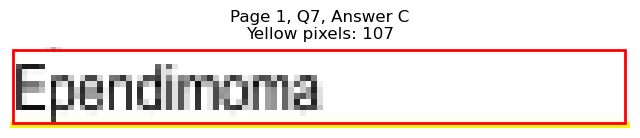

Page 1, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=396.3, y1=518.6
Page 1, Q7, D: Yellow pixels: 1247
Page 1, Q7, D: Total non-white pixels: 1680
Page 1, Q7, D: Yellow percentage: 74.2%


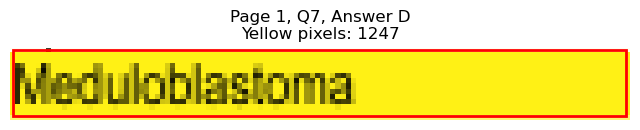


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=131.5, y1=581.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 317
Page 1, Q8, A: Yellow percentage: 0.0%


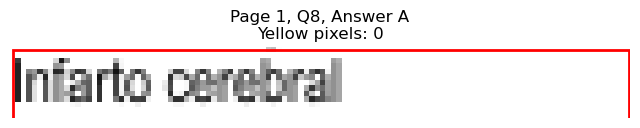

Page 1, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=139.0, y1=594.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 382
Page 1, Q8, B: Yellow percentage: 0.0%


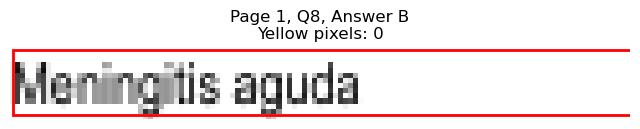

Page 1, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=391.3, y1=581.8
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 417
Page 1, Q8, C: Yellow percentage: 0.0%


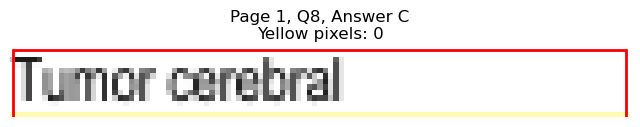

Page 1, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=438.9, y1=594.4
Page 1, Q8, D: Yellow pixels: 1512
Page 1, Q8, D: Total non-white pixels: 2268
Page 1, Q8, D: Yellow percentage: 66.7%


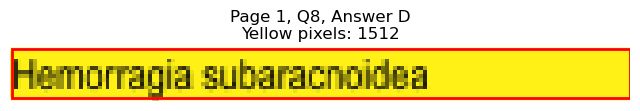


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=124.5, y1=657.5
Page 1, Q9, A: Yellow pixels: 107
Page 1, Q9, A: Total non-white pixels: 408
Page 1, Q9, A: Yellow percentage: 26.2%


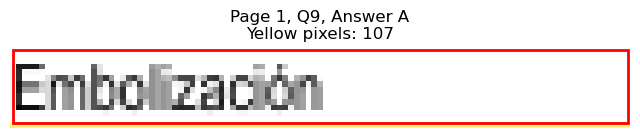

Page 1, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=148.1, y1=670.1
Page 1, Q9, B: Yellow pixels: 1395
Page 1, Q9, B: Total non-white pixels: 1834
Page 1, Q9, B: Yellow percentage: 76.1%


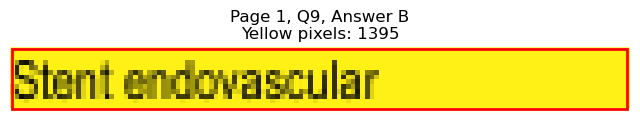

Page 1, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=357.7, y1=657.5
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 177
Page 1, Q9, C: Yellow percentage: 0.0%


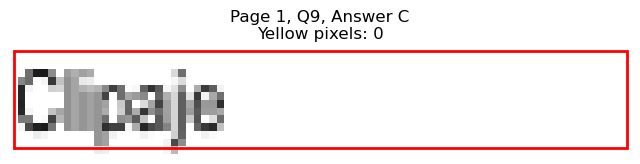

Page 1, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=372.2, y1=670.1
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 234
Page 1, Q9, D: Yellow percentage: 0.0%


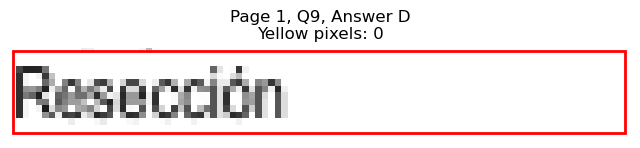


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=159.6, y1=708.0
Page 1, Q10, A: Yellow pixels: 1487
Page 1, Q10, A: Total non-white pixels: 1848
Page 1, Q10, A: Yellow percentage: 80.5%


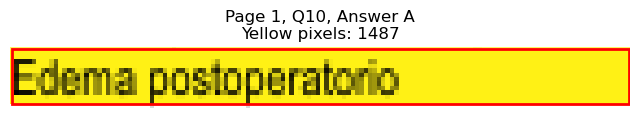

Page 1, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=171.6, y1=720.6
Page 1, Q10, B: Yellow pixels: 152
Page 1, Q10, B: Total non-white pixels: 676
Page 1, Q10, B: Yellow percentage: 22.5%


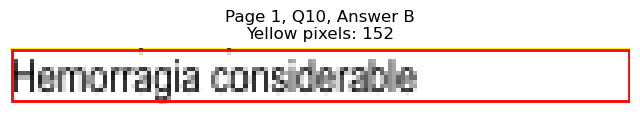

Page 1, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=471.1, y1=708.0
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 713
Page 1, Q10, C: Yellow percentage: 0.0%


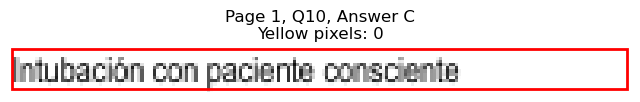

Page 1, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=476.6, y1=720.6
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 758
Page 1, Q10, D: Yellow percentage: 0.0%


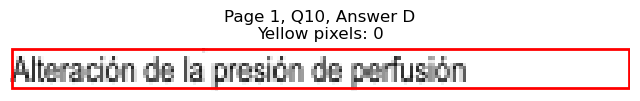


Page 1, Q10 - Selected Answer: A (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=168.6, y1=758.4
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 527
Page 1, Q11, A: Yellow percentage: 0.0%


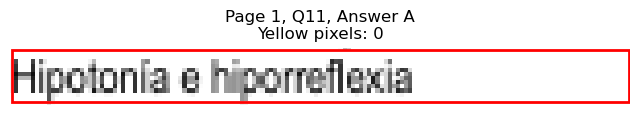

Page 1, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=281.9, y1=771.2
Page 1, Q11, B: Yellow pixels: 172
Page 1, Q11, B: Total non-white pixels: 1275
Page 1, Q11, B: Yellow percentage: 13.5%


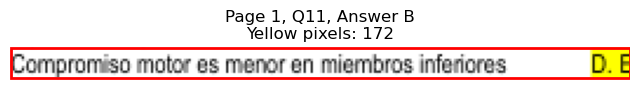

Page 1, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=455.9, y1=758.4
Page 1, Q11, C: Yellow pixels: 0
Page 1, Q11, C: Total non-white pixels: 615
Page 1, Q11, C: Yellow percentage: 0.0%


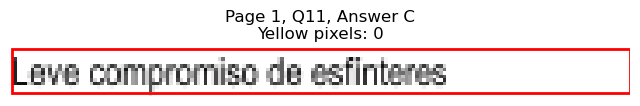

Page 1, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=515.6, y1=771.2
Page 1, Q11, D: Yellow pixels: 1721
Page 1, Q11, D: Total non-white pixels: 2646
Page 1, Q11, D: Yellow percentage: 65.0%


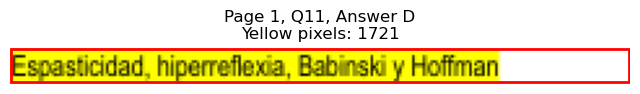


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=215.8, y1=114.7
Page 2, Q1, A: Yellow pixels: 2
Page 2, Q1, A: Total non-white pixels: 921
Page 2, Q1, A: Yellow percentage: 0.2%


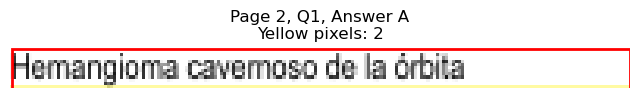

Page 2, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=188.2, y1=127.3
Page 2, Q1, B: Yellow pixels: 1555
Page 2, Q1, B: Total non-white pixels: 2394
Page 2, Q1, B: Yellow percentage: 65.0%


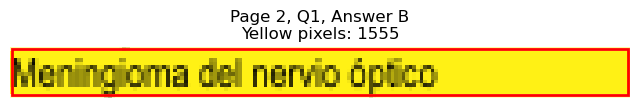

Page 2, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=455.5, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 655
Page 2, Q1, C: Yellow percentage: 0.0%


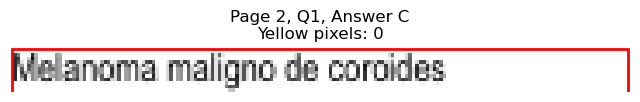

Page 2, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=426.9, y1=127.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 473
Page 2, Q1, D: Yellow percentage: 0.0%


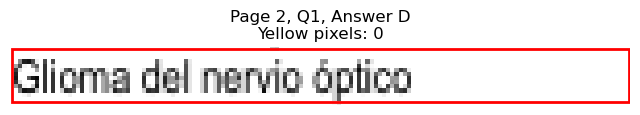


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=360.2, y1=165.2
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 1446
Page 2, Q2, A: Yellow percentage: 0.0%


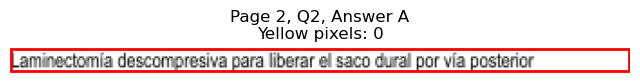

Page 2, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=189.1, y1=177.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 745
Page 2, Q2, B: Yellow percentage: 0.0%


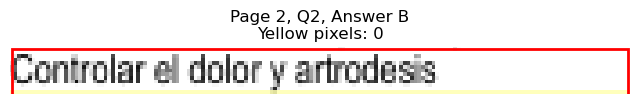

Page 2, Q2 - C: Detected box: x0=68.8, y0=177.7, x1=322.0, y1=190.4
Page 2, Q2, C: Yellow pixels: 2767
Page 2, Q2, C: Total non-white pixels: 4270
Page 2, Q2, C: Yellow percentage: 64.8%


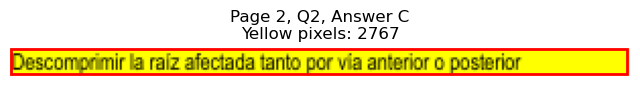

Page 2, Q2 - D: Detected box: x0=68.8, y0=190.3, x1=192.1, y1=203.0
Page 2, Q2, D: Yellow pixels: 3
Page 2, Q2, D: Total non-white pixels: 776
Page 2, Q2, D: Yellow percentage: 0.4%


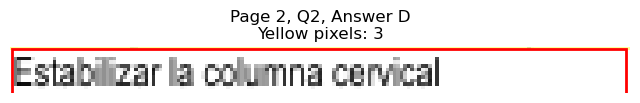


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=142.1, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 376
Page 2, Q3, A: Yellow percentage: 0.0%


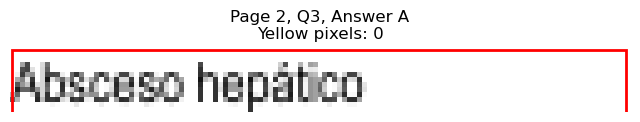

Page 2, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=115.5, y1=253.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 256
Page 2, Q3, B: Yellow percentage: 0.0%


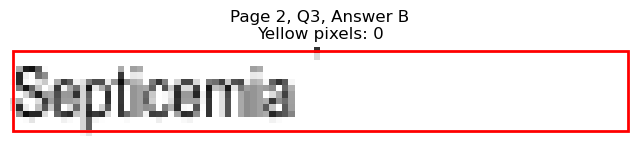

Page 2, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=371.7, y1=240.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 318
Page 2, Q3, C: Yellow percentage: 0.0%


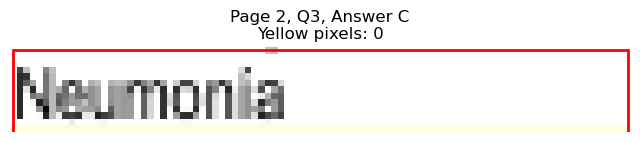

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=407.3, y1=253.5
Page 2, Q3, D: Yellow pixels: 1401
Page 2, Q3, D: Total non-white pixels: 1834
Page 2, Q3, D: Yellow percentage: 76.4%


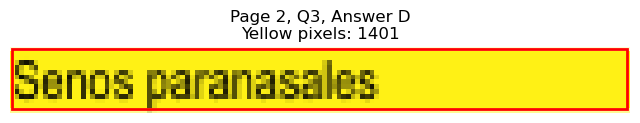


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=124.5, y1=316.7
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 394
Page 2, Q4, A: Yellow percentage: 0.0%


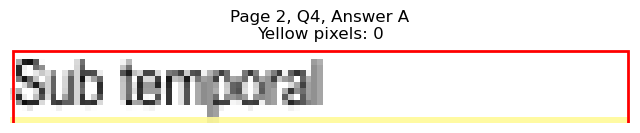

Page 2, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=141.0, y1=329.3
Page 2, Q4, B: Yellow pixels: 1199
Page 2, Q4, B: Total non-white pixels: 1736
Page 2, Q4, B: Yellow percentage: 69.1%


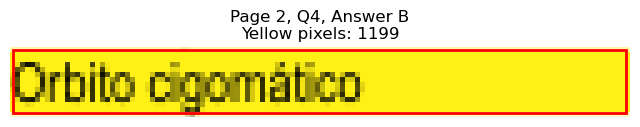

Page 2, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=378.7, y1=316.7
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 270
Page 2, Q4, C: Yellow percentage: 0.0%


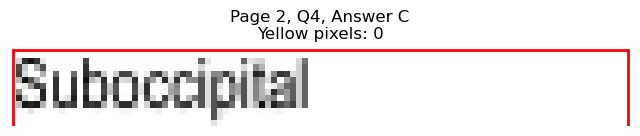

Page 2, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=431.8, y1=329.3
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 560
Page 2, Q4, D: Yellow percentage: 0.0%


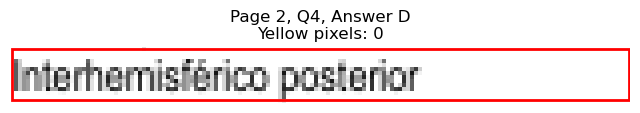


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=153.5, y1=392.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 457
Page 2, Q5, A: Yellow percentage: 0.0%


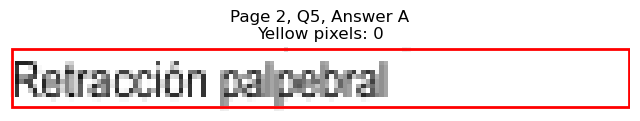

Page 2, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=156.0, y1=405.0
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 481
Page 2, Q5, B: Yellow percentage: 0.0%


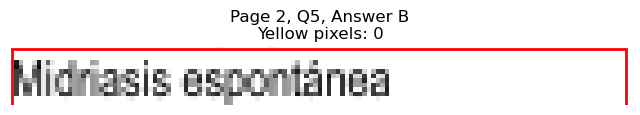

Page 2, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=441.4, y1=392.4
Page 2, Q5, C: Yellow pixels: 1566
Page 2, Q5, C: Total non-white pixels: 2310
Page 2, Q5, C: Yellow percentage: 67.8%


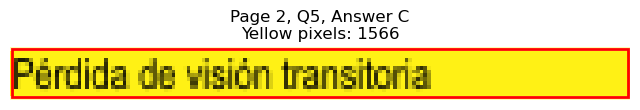

Page 2, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=432.4, y1=405.0
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 710
Page 2, Q5, D: Yellow percentage: 0.0%


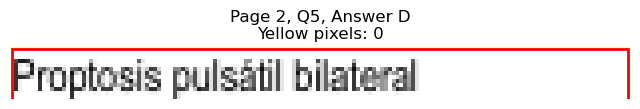


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=102.4, y1=442.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 251
Page 2, Q6, A: Yellow percentage: 0.0%


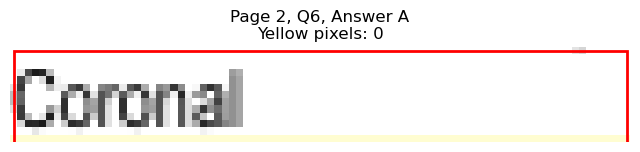

Page 2, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=98.4, y1=455.5
Page 2, Q6, B: Yellow pixels: 914
Page 2, Q6, B: Total non-white pixels: 1134
Page 2, Q6, B: Yellow percentage: 80.6%


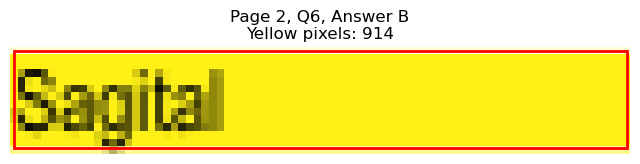

Page 2, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=366.7, y1=442.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 216
Page 2, Q6, C: Yellow percentage: 0.0%


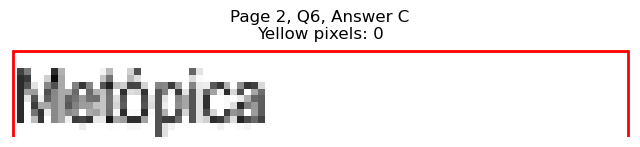

Page 2, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=379.7, y1=455.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 262
Page 2, Q6, D: Yellow percentage: 0.0%


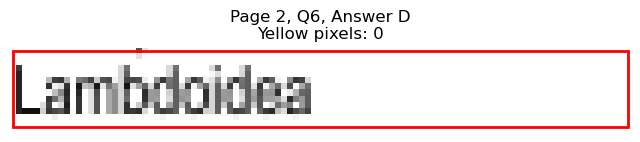


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=106.5, y1=506.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 200
Page 2, Q7, A: Yellow percentage: 0.0%


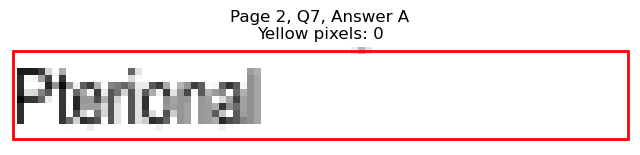

Page 2, Q7 - B: Detected box: x0=68.3, y0=316.6, x1=141.0, y1=329.3
Page 2, Q7, B: Yellow pixels: 1199
Page 2, Q7, B: Total non-white pixels: 1736
Page 2, Q7, B: Yellow percentage: 69.1%


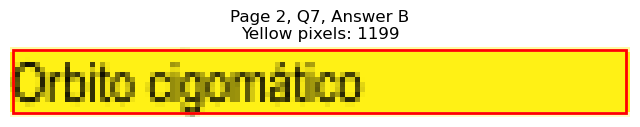

Page 2, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=383.7, y1=506.0
Page 2, Q7, C: Yellow pixels: 107
Page 2, Q7, C: Total non-white pixels: 484
Page 2, Q7, C: Yellow percentage: 22.1%


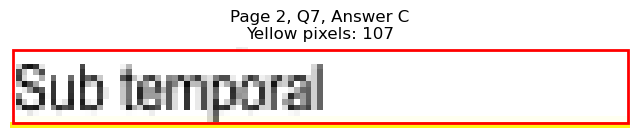

Page 2, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=427.4, y1=518.6
Page 2, Q7, D: Yellow pixels: 1549
Page 2, Q7, D: Total non-white pixels: 2114
Page 2, Q7, D: Yellow percentage: 73.3%


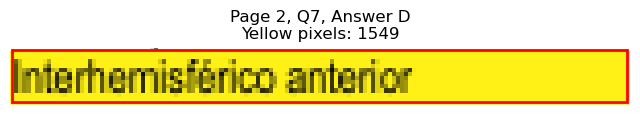


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=207.8, y1=556.4
Page 2, Q8, A: Yellow pixels: 1915
Page 2, Q8, A: Total non-white pixels: 2660
Page 2, Q8, A: Yellow percentage: 72.0%


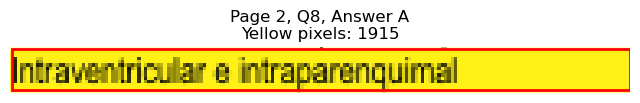

Page 2, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=167.1, y1=569.2
Page 2, Q8, B: Yellow pixels: 150
Page 2, Q8, B: Total non-white pixels: 626
Page 2, Q8, B: Yellow percentage: 24.0%


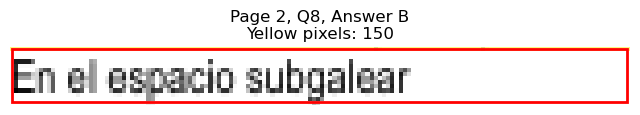

Page 2, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=407.8, y1=556.4
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 398
Page 2, Q8, C: Yellow percentage: 0.0%


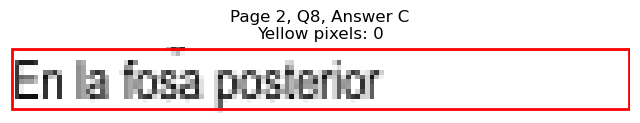

Page 2, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=462.4, y1=569.2
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 649
Page 2, Q8, D: Yellow percentage: 0.0%


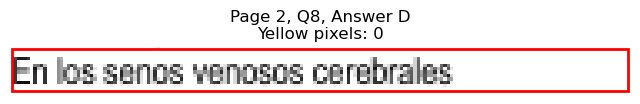


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=289.6, y1=607.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 1085
Page 2, Q9, A: Yellow percentage: 0.0%


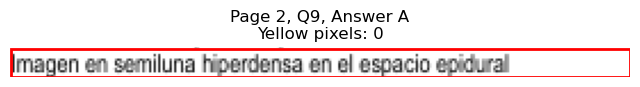

Page 2, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=223.2, y1=619.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 766
Page 2, Q9, B: Yellow percentage: 0.0%


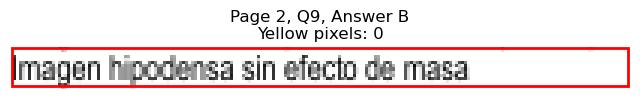

Page 2, Q9 - C: Detected box: x0=68.8, y0=619.6, x1=225.8, y1=632.3
Page 2, Q9, C: Yellow pixels: 208
Page 2, Q9, C: Total non-white pixels: 1010
Page 2, Q9, C: Yellow percentage: 20.6%


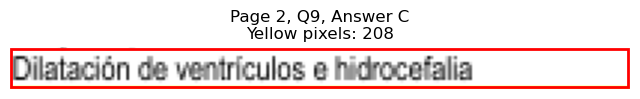

Page 2, Q9 - D: Detected box: x0=68.8, y0=632.2, x1=392.8, y1=644.9
Page 2, Q9, D: Yellow pixels: 3752
Page 2, Q9, D: Total non-white pixels: 4875
Page 2, Q9, D: Yellow percentage: 77.0%


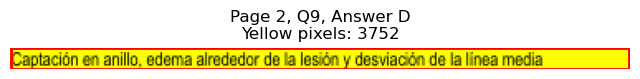


Page 2, Q9 - Selected Answer: D (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=155.1, y1=695.3
Page 2, Q10, A: Yellow pixels: 1337
Page 2, Q10, A: Total non-white pixels: 1932
Page 2, Q10, A: Yellow percentage: 69.2%


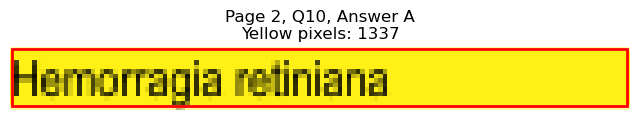

Page 2, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=159.6, y1=708.0
Page 2, Q10, B: Yellow pixels: 1
Page 2, Q10, B: Total non-white pixels: 596
Page 2, Q10, B: Yellow percentage: 0.2%


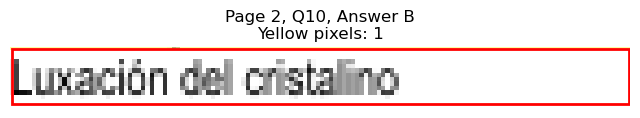

Page 2, Q10 - C: Detected box: x0=327.5, y0=682.7, x1=435.9, y1=695.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 547
Page 2, Q10, C: Yellow percentage: 0.0%


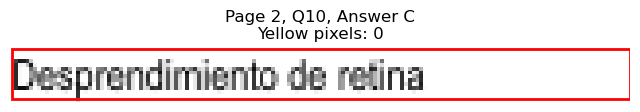

Page 2, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=411.3, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 452
Page 2, Q10, D: Yellow percentage: 0.0%


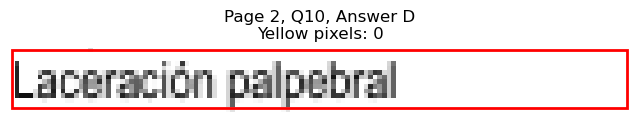


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=223.4, y1=102.1
Page 3, Q1, A: Yellow pixels: 206
Page 3, Q1, A: Total non-white pixels: 981
Page 3, Q1, A: Yellow percentage: 21.0%


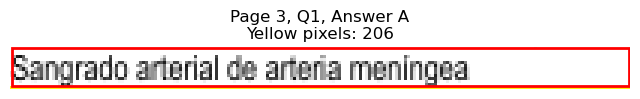

Page 3, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=359.7, y1=114.7
Page 3, Q1, B: Yellow pixels: 3358
Page 3, Q1, B: Total non-white pixels: 4446
Page 3, Q1, B: Yellow percentage: 75.5%


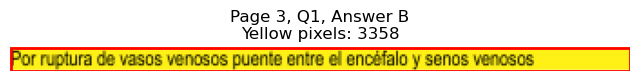

Page 3, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=186.1, y1=127.3
Page 3, Q1, C: Yellow pixels: 169
Page 3, Q1, C: Total non-white pixels: 768
Page 3, Q1, C: Yellow percentage: 22.0%


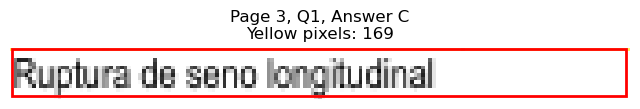

Page 3, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=222.3, y1=139.9
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 759
Page 3, Q1, D: Yellow percentage: 0.0%


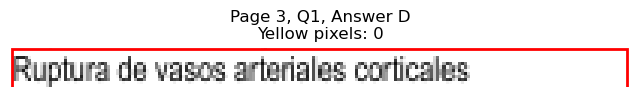


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=161.5, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 633
Page 3, Q2, A: Yellow percentage: 0.0%


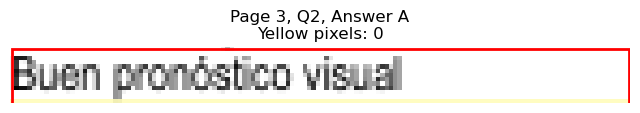

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=238.4, y1=190.4
Page 3, Q2, B: Yellow pixels: 1916
Page 3, Q2, B: Total non-white pixels: 2996
Page 3, Q2, B: Yellow percentage: 64.0%


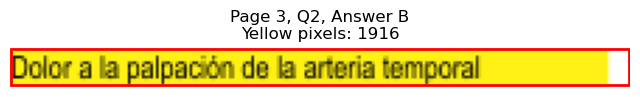

Page 3, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=507.7, y1=177.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 932
Page 3, Q2, C: Yellow percentage: 0.0%


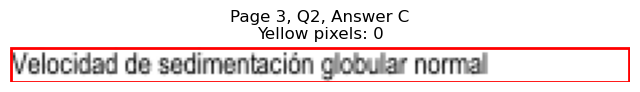

Page 3, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=427.4, y1=190.4
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 530
Page 3, Q2, D: Yellow percentage: 0.0%


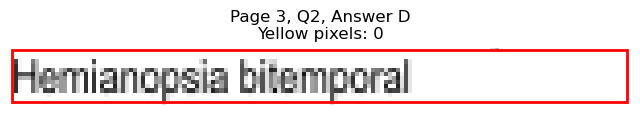


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=83.9, y1=240.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 79
Page 3, Q3, A: Yellow percentage: 0.0%


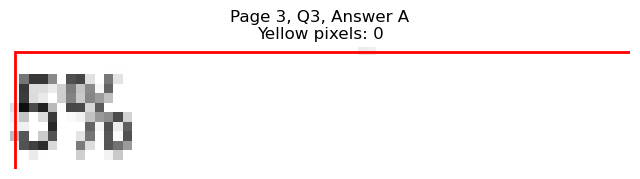

Page 3, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=88.8, y1=253.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 90
Page 3, Q3, B: Yellow percentage: 0.0%


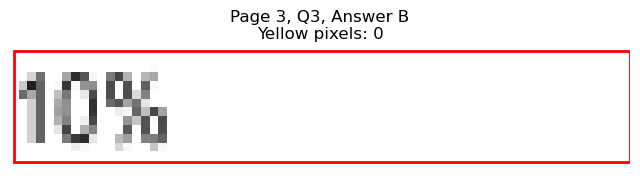

Page 3, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=380.2, y1=240.9
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 364
Page 3, Q3, C: Yellow percentage: 0.0%


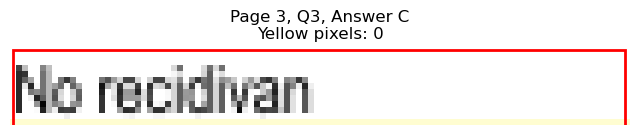

Page 3, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=348.1, y1=253.5
Page 3, Q3, D: Yellow pixels: 860
Page 3, Q3, D: Total non-white pixels: 1008
Page 3, Q3, D: Yellow percentage: 85.3%


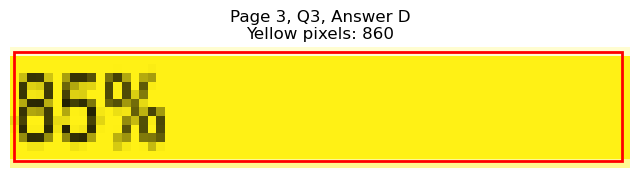


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=133.5, y1=291.5
Page 3, Q4, A: Yellow pixels: 116
Page 3, Q4, A: Total non-white pixels: 427
Page 3, Q4, A: Yellow percentage: 27.2%


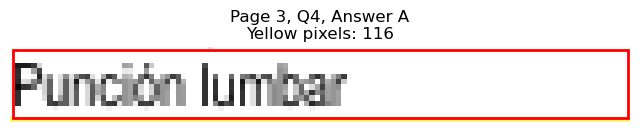

Page 3, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=205.7, y1=304.1
Page 3, Q4, B: Yellow pixels: 1945
Page 3, Q4, B: Total non-white pixels: 2632
Page 3, Q4, B: Yellow percentage: 73.9%


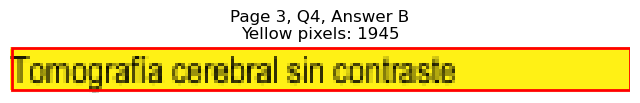

Page 3, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=431.3, y1=291.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 533
Page 3, Q4, C: Yellow percentage: 0.0%


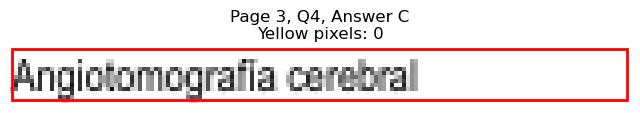

Page 3, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=468.0, y1=304.1
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 698
Page 3, Q4, D: Yellow percentage: 0.0%


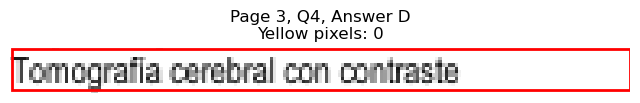


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=142.0, y1=341.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 344
Page 3, Q5, A: Yellow percentage: 0.0%


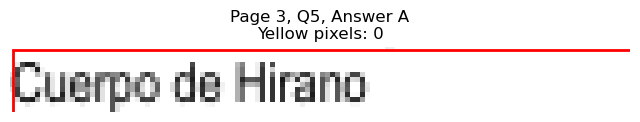

Page 3, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=143.1, y1=354.6
Page 3, Q5, B: Yellow pixels: 1363
Page 3, Q5, B: Total non-white pixels: 1764
Page 3, Q5, B: Yellow percentage: 77.3%


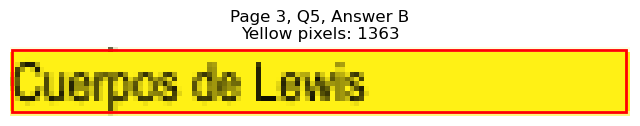

Page 3, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=394.7, y1=341.9
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 332
Page 3, Q5, C: Yellow percentage: 0.0%


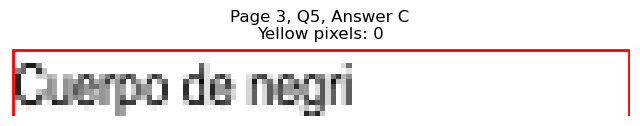

Page 3, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=416.8, y1=354.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 480
Page 3, Q5, D: Yellow percentage: 0.0%


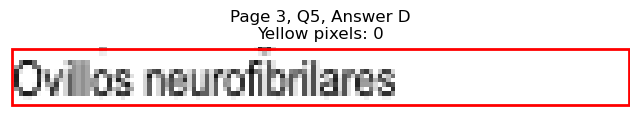


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=346.0, y1=392.4
Page 3, Q6, A: Yellow pixels: 329
Page 3, Q6, A: Total non-white pixels: 1680
Page 3, Q6, A: Yellow percentage: 19.6%


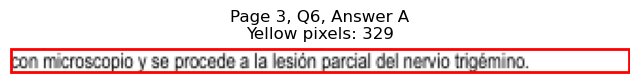

Page 3, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=332.1, y1=405.0
Page 3, Q6, B: Yellow pixels: 3128
Page 3, Q6, B: Total non-white pixels: 4095
Page 3, Q6, B: Yellow percentage: 76.4%


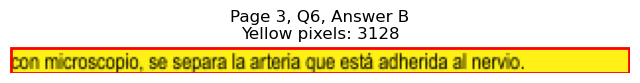

Page 3, Q6 - C: Detected box: x0=68.8, y0=404.9, x1=240.9, y1=417.6
Page 3, Q6, C: Yellow pixels: 217
Page 3, Q6, C: Total non-white pixels: 1039
Page 3, Q6, C: Yellow percentage: 20.9%


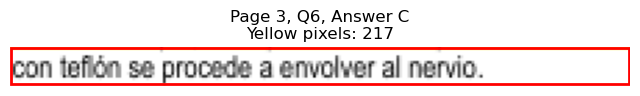

Page 3, Q6 - D: Detected box: x0=68.8, y0=417.6, x1=388.7, y1=430.3
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 1519
Page 3, Q6, D: Yellow percentage: 0.0%


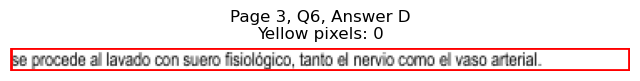


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=130.9, y1=480.7
Page 3, Q7, A: Yellow pixels: 1231
Page 3, Q7, A: Total non-white pixels: 1469
Page 3, Q7, A: Yellow percentage: 83.8%


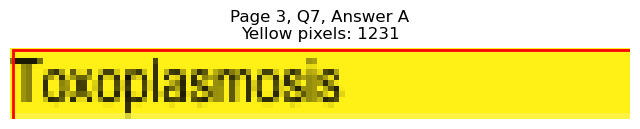

Page 3, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=144.5, y1=493.4
Page 3, Q7, B: Yellow pixels: 127
Page 3, Q7, B: Total non-white pixels: 530
Page 3, Q7, B: Yellow percentage: 24.0%


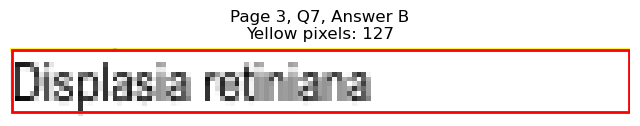

Page 3, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=434.3, y1=480.7
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 539
Page 3, Q7, C: Yellow percentage: 0.0%


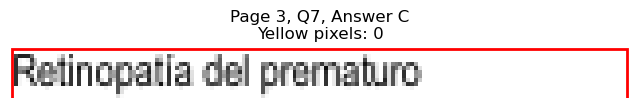

Page 3, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=385.3, y1=493.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 306
Page 3, Q7, D: Yellow percentage: 0.0%


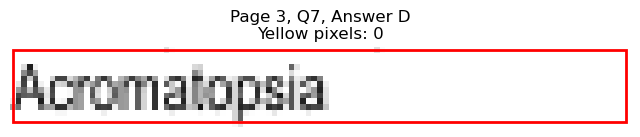


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=147.5, y1=556.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 411
Page 3, Q8, A: Yellow percentage: 0.0%


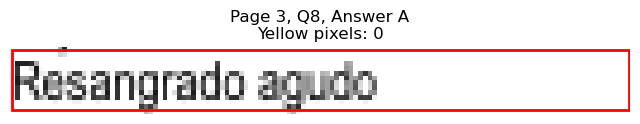

Page 3, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=152.1, y1=569.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 432
Page 3, Q8, B: Yellow percentage: 0.0%


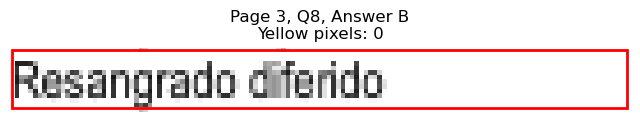

Page 3, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=460.4, y1=556.4
Page 3, Q8, C: Yellow pixels: 1868
Page 3, Q8, C: Total non-white pixels: 2576
Page 3, Q8, C: Yellow percentage: 72.5%


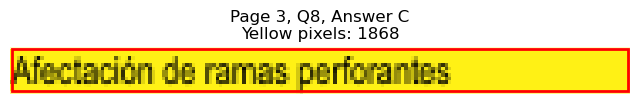

Page 3, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=387.2, y1=569.2
Page 3, Q8, D: Yellow pixels: 111
Page 3, Q8, D: Total non-white pixels: 419
Page 3, Q8, D: Yellow percentage: 26.5%


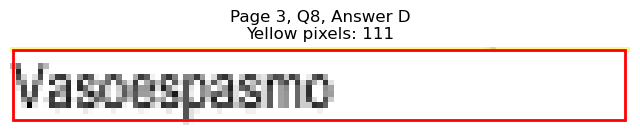


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=303.5, y1=632.3
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 1184
Page 3, Q9, A: Yellow percentage: 0.0%


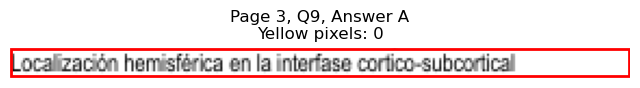

Page 3, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=312.6, y1=644.9
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 1513
Page 3, Q9, B: Yellow percentage: 0.0%


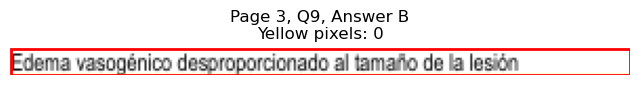

Page 3, Q9 - C: Detected box: x0=68.8, y0=644.9, x1=429.9, y1=657.5
Page 3, Q9, C: Yellow pixels: 3968
Page 3, Q9, C: Total non-white pixels: 5768
Page 3, Q9, C: Yellow percentage: 68.8%


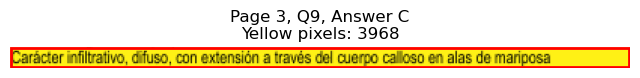

Page 3, Q9 - D: Detected box: x0=68.8, y0=657.5, x1=250.8, y1=670.1
Page 3, Q9, D: Yellow pixels: 233
Page 3, Q9, D: Total non-white pixels: 1152
Page 3, Q9, D: Yellow percentage: 20.2%


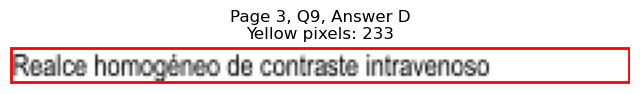


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=149.1, y1=733.2
Page 3, Q10, A: Yellow pixels: 1387
Page 3, Q10, A: Total non-white pixels: 1848
Page 3, Q10, A: Yellow percentage: 75.1%


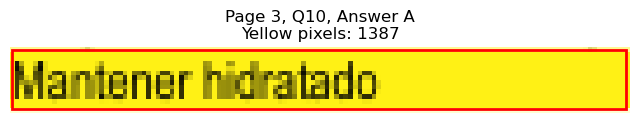

Page 3, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=106.9, y1=745.8
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 287
Page 3, Q10, B: Yellow percentage: 0.0%


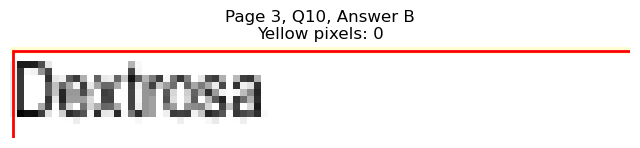

Page 3, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=407.3, y1=733.2
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 412
Page 3, Q10, C: Yellow percentage: 0.0%


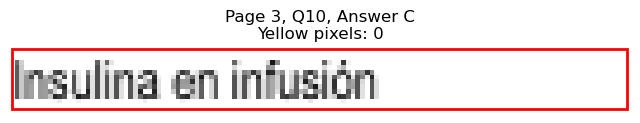

Page 3, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=426.9, y1=745.8
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 506
Page 3, Q10, D: Yellow percentage: 0.0%


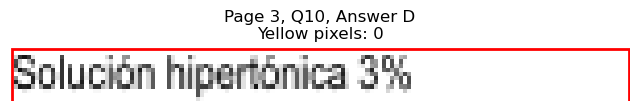


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=275.4, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 1047
Page 4, Q1, A: Yellow percentage: 0.0%


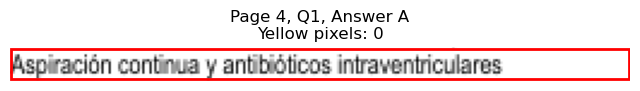

Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=263.8, y1=114.7
Page 4, Q1, B: Yellow pixels: 2
Page 4, Q1, B: Total non-white pixels: 1240
Page 4, Q1, B: Yellow percentage: 0.2%


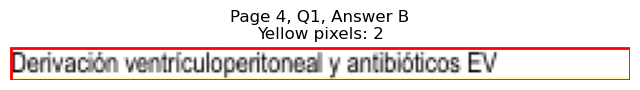

Page 4, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=304.0, y1=127.3
Page 4, Q1, C: Yellow pixels: 2486
Page 4, Q1, C: Total non-white pixels: 4018
Page 4, Q1, C: Yellow percentage: 61.9%


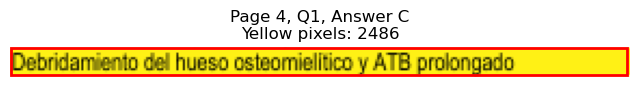

Page 4, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=266.9, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 1287
Page 4, Q1, D: Yellow percentage: 0.0%


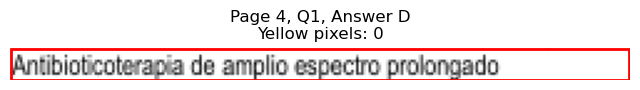


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=204.2, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 830
Page 4, Q2, A: Yellow percentage: 0.0%


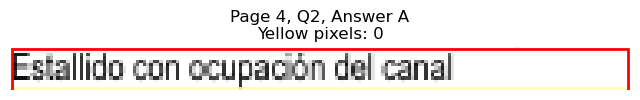

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=226.4, y1=190.4
Page 4, Q2, B: Yellow pixels: 1933
Page 4, Q2, B: Total non-white pixels: 2926
Page 4, Q2, B: Yellow percentage: 66.1%


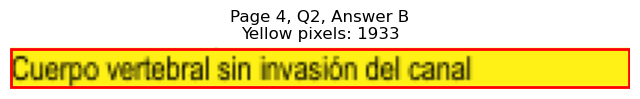

Page 4, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=483.0, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 779
Page 4, Q2, C: Yellow percentage: 0.0%


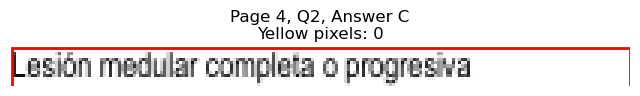

Page 4, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=455.5, y1=190.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 645
Page 4, Q2, D: Yellow percentage: 0.0%


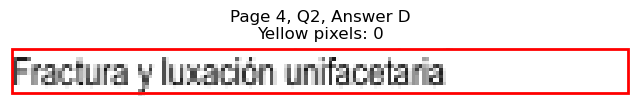


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=240.9, y1=228.3
Page 4, Q3, A: Yellow pixels: 2012
Page 4, Q3, A: Total non-white pixels: 3122
Page 4, Q3, A: Yellow percentage: 64.4%


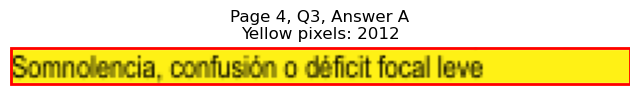

Page 4, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=400.4, y1=240.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 2016
Page 4, Q3, B: Yellow percentage: 0.0%


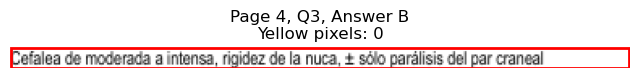

Page 4, Q3 - C: Detected box: x0=68.8, y0=240.9, x1=424.9, y1=253.5
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 1782
Page 4, Q3, C: Yellow percentage: 0.0%


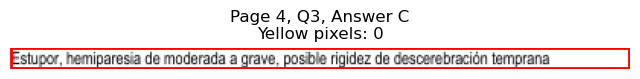

Page 4, Q3 - D: Detected box: x0=68.8, y0=253.5, x1=323.4, y1=266.1
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 1310
Page 4, Q3, D: Yellow percentage: 0.0%


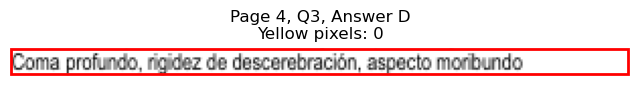


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=206.7, y1=304.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 670
Page 4, Q4, A: Yellow percentage: 0.0%


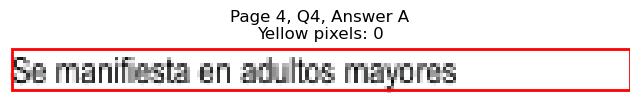

Page 4, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=230.8, y1=316.7
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 783
Page 4, Q4, B: Yellow percentage: 0.0%


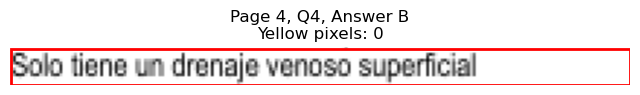

Page 4, Q4 - C: Detected box: x0=68.8, y0=316.6, x1=175.1, y1=329.3
Page 4, Q4, C: Yellow pixels: 158
Page 4, Q4, C: Total non-white pixels: 680
Page 4, Q4, C: Yellow percentage: 23.2%


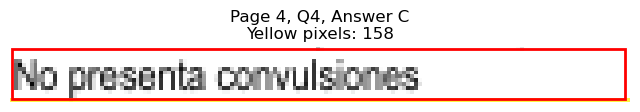

Page 4, Q4 - D: Detected box: x0=68.8, y0=329.2, x1=317.1, y1=341.9
Page 4, Q4, D: Yellow pixels: 2964
Page 4, Q4, D: Total non-white pixels: 3900
Page 4, Q4, D: Yellow percentage: 76.0%


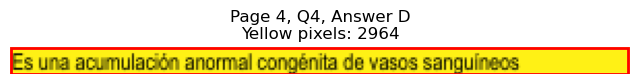


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=137.1, y1=379.8
Page 4, Q5, A: Yellow pixels: 1250
Page 4, Q5, A: Total non-white pixels: 1560
Page 4, Q5, A: Yellow percentage: 80.1%


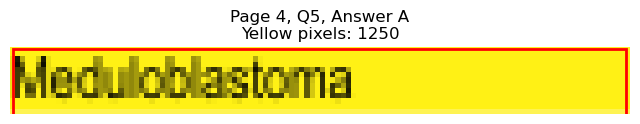

Page 4, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=128.5, y1=392.4
Page 4, Q5, B: Yellow pixels: 111
Page 4, Q5, B: Total non-white pixels: 406
Page 4, Q5, B: Yellow percentage: 27.3%


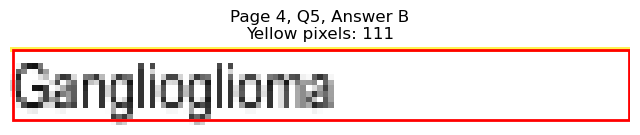

Page 4, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=379.1, y1=379.8
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 283
Page 4, Q5, C: Yellow percentage: 0.0%


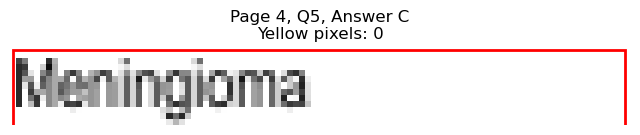

Page 4, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=443.3, y1=392.4
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 572
Page 4, Q5, D: Yellow percentage: 0.0%


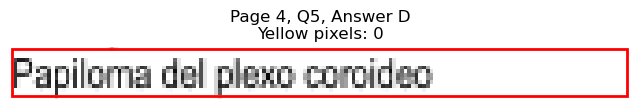


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=234.8, y1=430.3
Page 4, Q6, A: Yellow pixels: 217
Page 4, Q6, A: Total non-white pixels: 1059
Page 4, Q6, A: Yellow percentage: 20.5%


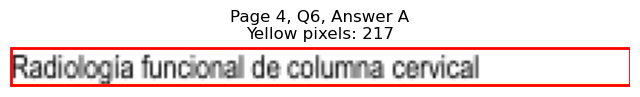

Page 4, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=321.5, y1=442.9
Page 4, Q6, B: Yellow pixels: 2977
Page 4, Q6, B: Total non-white pixels: 3952
Page 4, Q6, B: Yellow percentage: 75.3%


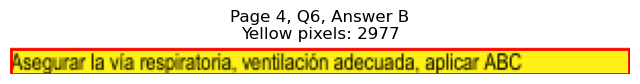

Page 4, Q6 - C: Detected box: x0=68.8, y0=442.8, x1=146.5, y1=455.5
Page 4, Q6, C: Yellow pixels: 122
Page 4, Q6, C: Total non-white pixels: 515
Page 4, Q6, C: Yellow percentage: 23.7%


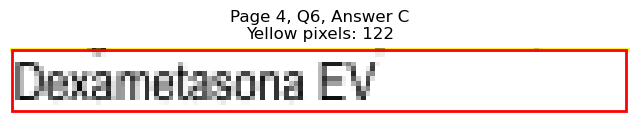

Page 4, Q6 - D: Detected box: x0=68.8, y0=455.5, x1=177.6, y1=468.1
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 552
Page 4, Q6, D: Yellow percentage: 0.0%


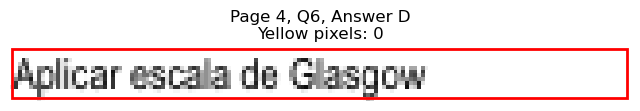


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=119.9, y1=506.0
Page 4, Q7, A: Yellow pixels: 102
Page 4, Q7, A: Total non-white pixels: 485
Page 4, Q7, A: Yellow percentage: 21.0%


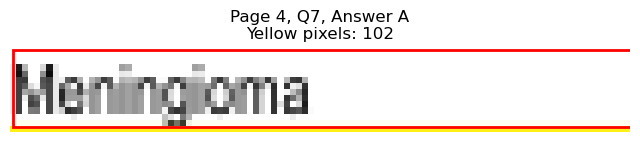

Page 4, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=113.9, y1=518.6
Page 4, Q7, B: Yellow pixels: 1048
Page 4, Q7, B: Total non-white pixels: 1344
Page 4, Q7, B: Yellow percentage: 78.0%


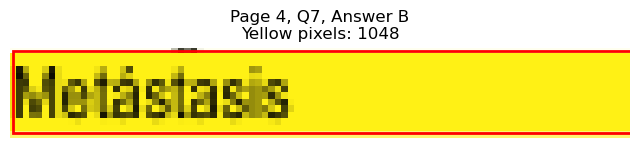

Page 4, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=427.4, y1=506.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 497
Page 4, Q7, C: Yellow percentage: 0.0%


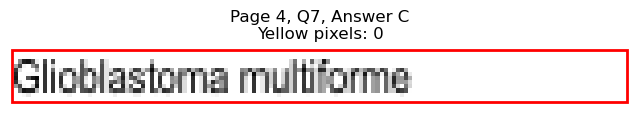

Page 4, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=401.7, y1=518.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 374
Page 4, Q7, D: Yellow percentage: 0.0%


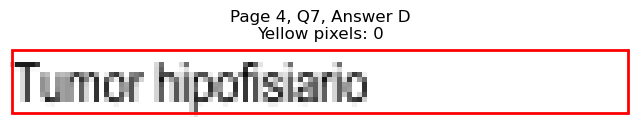


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=151.1, y1=556.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 384
Page 4, Q8, A: Yellow percentage: 0.0%


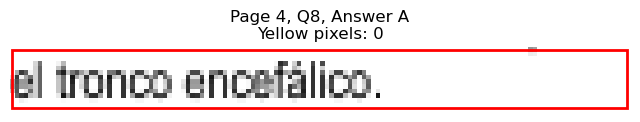

Page 4, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=117.5, y1=569.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 229
Page 4, Q8, B: Yellow percentage: 0.0%


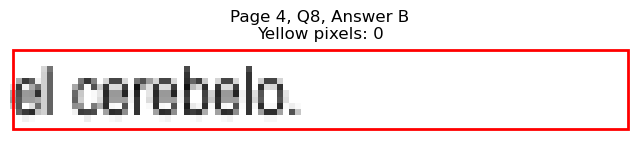

Page 4, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=403.7, y1=556.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 364
Page 4, Q8, C: Yellow percentage: 0.0%


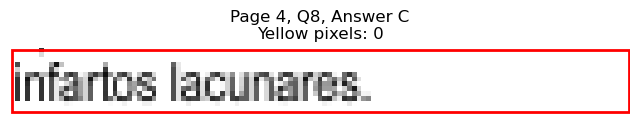

Page 4, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=487.5, y1=569.2
Page 4, Q8, D: Yellow pixels: 2149
Page 4, Q8, D: Total non-white pixels: 2954
Page 4, Q8, D: Yellow percentage: 72.7%


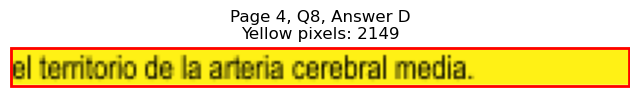


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=164.1, y1=607.0
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 478
Page 4, Q9, A: Yellow percentage: 0.0%


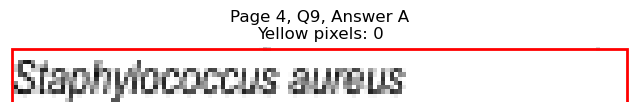

Page 4, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=175.6, y1=619.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 534
Page 4, Q9, B: Yellow percentage: 0.0%


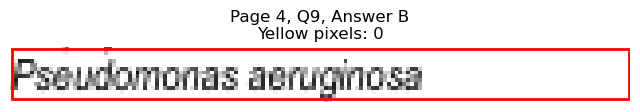

Page 4, Q9 - C: Detected box: x0=327.5, y0=594.3, x1=399.3, y1=607.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 497
Page 4, Q9, C: Yellow percentage: 0.0%


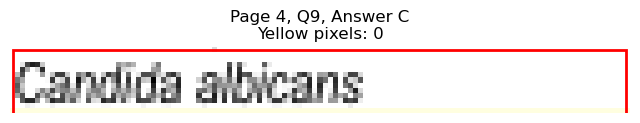

Page 4, Q9 - D: Detected box: x0=327.5, y0=606.9, x1=405.8, y1=619.6
Page 4, Q9, D: Yellow pixels: 1365
Page 4, Q9, D: Total non-white pixels: 1806
Page 4, Q9, D: Yellow percentage: 75.6%


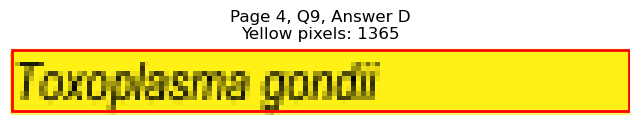


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=186.1, y1=670.1
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 610
Page 4, Q10, A: Yellow percentage: 0.0%


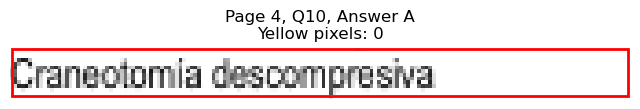

Page 4, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=133.5, y1=682.7
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 311
Page 4, Q10, B: Yellow percentage: 0.0%


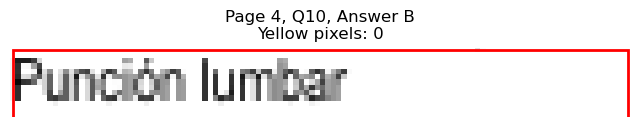

Page 4, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=479.0, y1=670.1
Page 4, Q10, C: Yellow pixels: 203
Page 4, Q10, C: Total non-white pixels: 957
Page 4, Q10, C: Yellow percentage: 21.2%


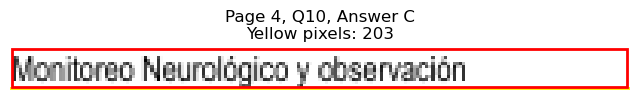

Page 4, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=411.3, y1=682.7
Page 4, Q10, D: Yellow pixels: 1435
Page 4, Q10, D: Total non-white pixels: 1755
Page 4, Q10, D: Yellow percentage: 81.8%


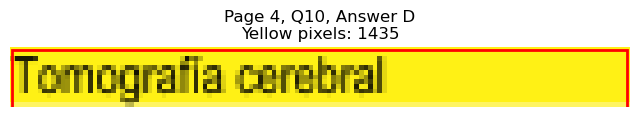


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=129.5, y1=720.6
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 329
Page 4, Q11, A: Yellow percentage: 0.0%


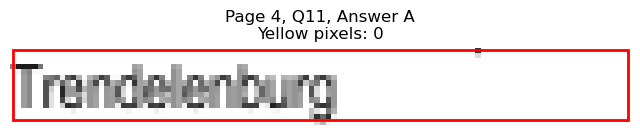

Page 4, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=204.2, y1=733.2
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 670
Page 4, Q11, B: Yellow percentage: 0.0%


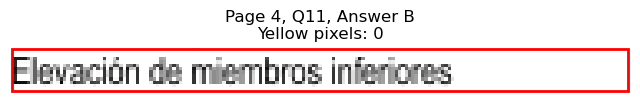

Page 4, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=439.4, y1=720.6
Page 4, Q11, C: Yellow pixels: 163
Page 4, Q11, C: Total non-white pixels: 768
Page 4, Q11, C: Yellow percentage: 21.2%


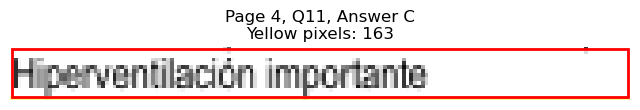

Page 4, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=417.9, y1=733.2
Page 4, Q11, D: Yellow pixels: 1458
Page 4, Q11, D: Total non-white pixels: 1974
Page 4, Q11, D: Yellow percentage: 73.9%


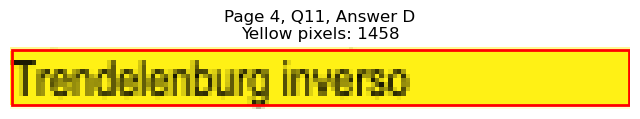


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=252.4, y1=102.1
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 935
Page 5, Q1, A: Yellow percentage: 0.0%


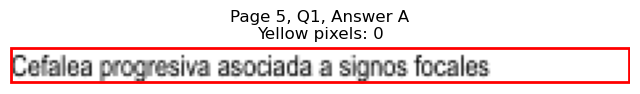

Page 5, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=322.0, y1=114.7
Page 5, Q1, B: Yellow pixels: 5
Page 5, Q1, B: Total non-white pixels: 1550
Page 5, Q1, B: Yellow percentage: 0.3%


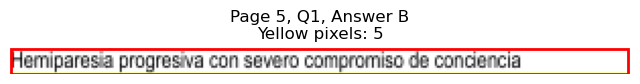

Page 5, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=374.7, y1=127.3
Page 5, Q1, C: Yellow pixels: 3163
Page 5, Q1, C: Total non-white pixels: 4998
Page 5, Q1, C: Yellow percentage: 63.3%


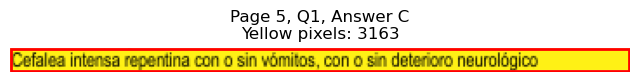

Page 5, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=360.7, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1750
Page 5, Q1, D: Yellow percentage: 0.0%


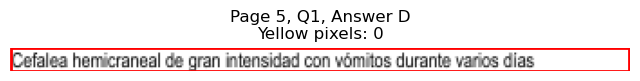


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=202.2, y1=177.8
Page 5, Q2, A: Yellow pixels: 1871
Page 5, Q2, A: Total non-white pixels: 2405
Page 5, Q2, A: Yellow percentage: 77.8%


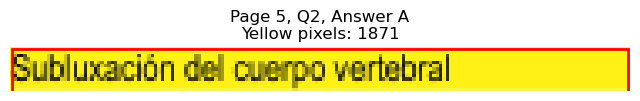

Page 5, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=205.2, y1=190.4
Page 5, Q2, B: Yellow pixels: 188
Page 5, Q2, B: Total non-white pixels: 860
Page 5, Q2, B: Yellow percentage: 21.9%


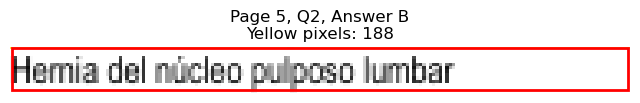

Page 5, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=162.0, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 455
Page 5, Q2, C: Yellow percentage: 0.0%


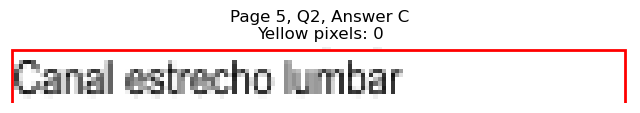

Page 5, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=281.4, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 1028
Page 5, Q2, D: Yellow percentage: 0.0%


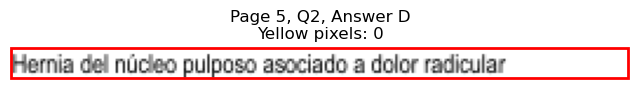


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=129.5, y1=253.5
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 334
Page 5, Q3, A: Yellow percentage: 0.0%


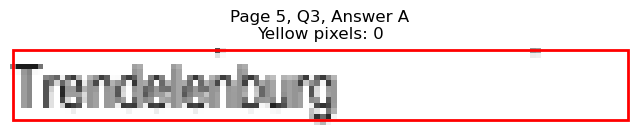

Page 5, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=107.9, y1=266.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 198
Page 5, Q3, B: Yellow percentage: 0.0%


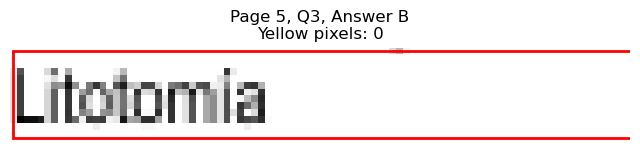

Page 5, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=395.2, y1=253.5
Page 5, Q3, C: Yellow pixels: 119
Page 5, Q3, C: Total non-white pixels: 460
Page 5, Q3, C: Yellow percentage: 25.9%


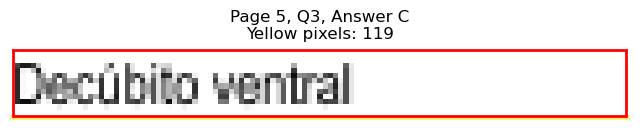

Page 5, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=391.3, y1=266.1
Page 5, Q3, D: Yellow pixels: 1257
Page 5, Q3, D: Total non-white pixels: 1610
Page 5, Q3, D: Yellow percentage: 78.1%


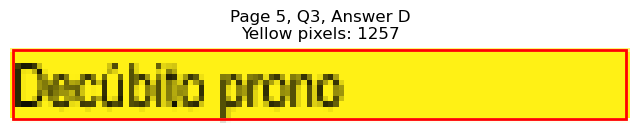


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=147.0, y1=316.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 534
Page 5, Q4, A: Yellow percentage: 0.0%


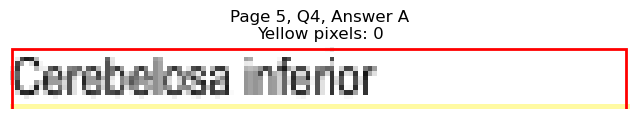

Page 5, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=152.1, y1=329.3
Page 5, Q4, B: Yellow pixels: 1304
Page 5, Q4, B: Total non-white pixels: 1890
Page 5, Q4, B: Yellow percentage: 69.0%


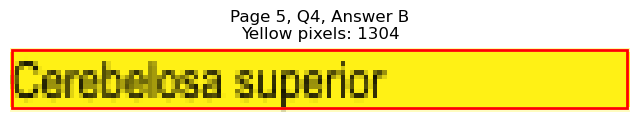

Page 5, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=402.3, y1=316.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 379
Page 5, Q4, C: Yellow percentage: 0.0%


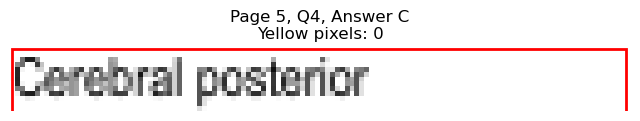

Page 5, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=366.7, y1=329.3
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 204
Page 5, Q4, D: Yellow percentage: 0.0%


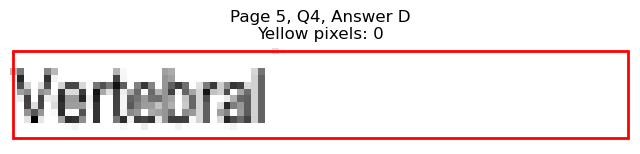


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=199.2, y1=367.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 657
Page 5, Q5, A: Yellow percentage: 0.0%


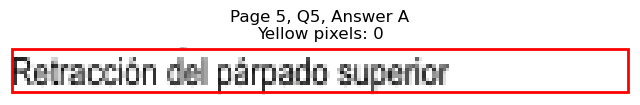

Page 5, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=146.5, y1=379.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 380
Page 5, Q5, B: Yellow percentage: 0.0%


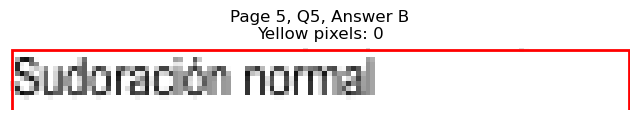

Page 5, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=404.8, y1=367.2
Page 5, Q5, C: Yellow pixels: 128
Page 5, Q5, C: Total non-white pixels: 553
Page 5, Q5, C: Yellow percentage: 23.1%


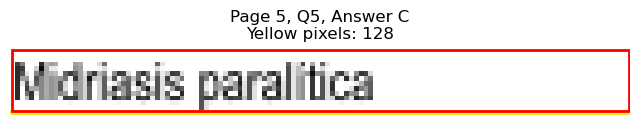

Page 5, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=417.3, y1=379.8
Page 5, Q5, D: Yellow pixels: 1517
Page 5, Q5, D: Total non-white pixels: 1833
Page 5, Q5, D: Yellow percentage: 82.8%


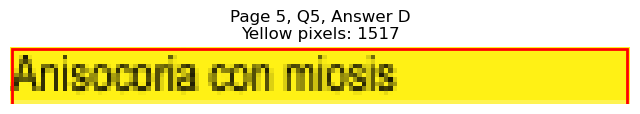


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=98.4, y1=417.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 156
Page 5, Q6, A: Yellow percentage: 0.0%


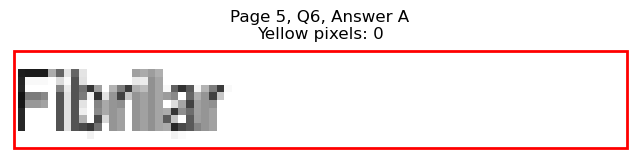

Page 5, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=115.0, y1=430.3
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 246
Page 5, Q6, B: Yellow percentage: 0.0%


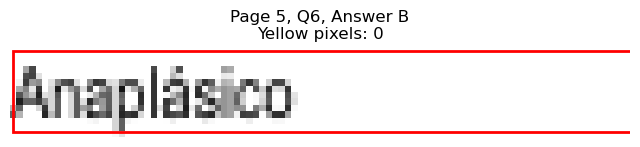

Page 5, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=366.2, y1=417.6
Page 5, Q6, C: Yellow pixels: 1026
Page 5, Q6, C: Total non-white pixels: 1260
Page 5, Q6, C: Yellow percentage: 81.4%


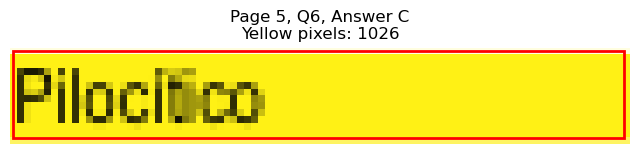

Page 5, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=427.4, y1=430.3
Page 5, Q6, D: Yellow pixels: 151
Page 5, Q6, D: Total non-white pixels: 648
Page 5, Q6, D: Yellow percentage: 23.3%


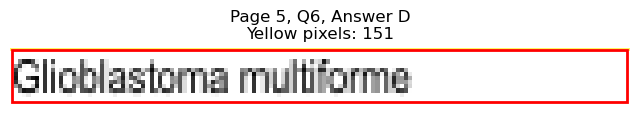


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=169.1, y1=493.4
Page 5, Q7, A: Yellow pixels: 152
Page 5, Q7, A: Total non-white pixels: 648
Page 5, Q7, A: Yellow percentage: 23.5%


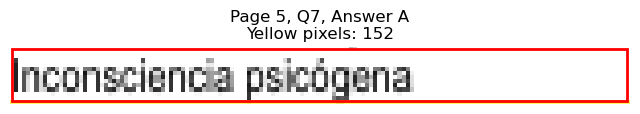

Page 5, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=236.8, y1=506.0
Page 5, Q7, B: Yellow pixels: 2123
Page 5, Q7, B: Total non-white pixels: 2782
Page 5, Q7, B: Yellow percentage: 76.3%


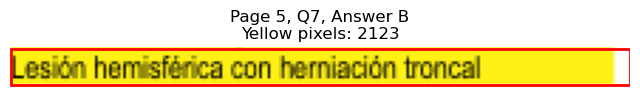

Page 5, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=433.9, y1=493.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 558
Page 5, Q7, C: Yellow percentage: 0.0%


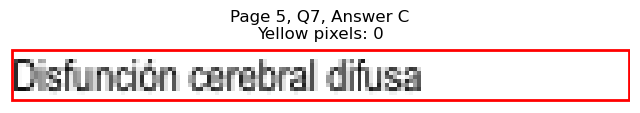

Page 5, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=431.3, y1=506.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 511
Page 5, Q7, D: Yellow percentage: 0.0%


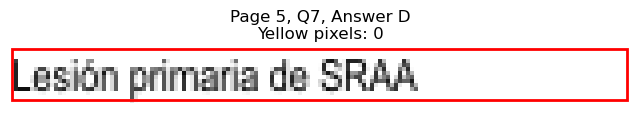


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=191.2, y1=556.4
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 616
Page 5, Q8, A: Yellow percentage: 0.0%


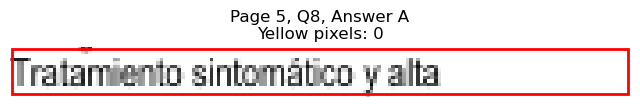

Page 5, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=205.2, y1=569.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 720
Page 5, Q8, B: Yellow percentage: 0.0%


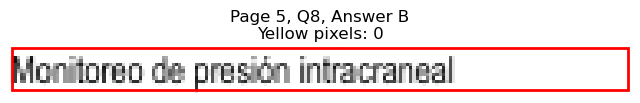

Page 5, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=419.3, y1=556.4
Page 5, Q8, C: Yellow pixels: 1466
Page 5, Q8, C: Total non-white pixels: 2002
Page 5, Q8, C: Yellow percentage: 73.2%


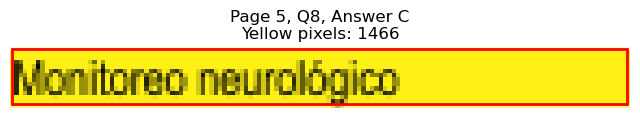

Page 5, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=392.7, y1=569.2
Page 5, Q8, D: Yellow pixels: 115
Page 5, Q8, D: Total non-white pixels: 423
Page 5, Q8, D: Yellow percentage: 27.2%


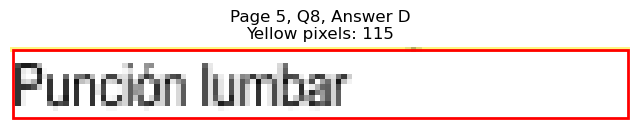


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=112.9, y1=619.6
Page 5, Q9, A: Yellow pixels: 1083
Page 5, Q9, A: Total non-white pixels: 1330
Page 5, Q9, A: Yellow percentage: 81.4%


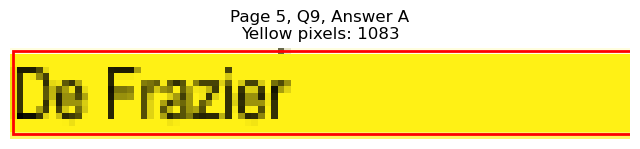

Page 5, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=125.9, y1=632.3
Page 5, Q9, B: Yellow pixels: 108
Page 5, Q9, B: Total non-white pixels: 391
Page 5, Q9, B: Yellow percentage: 27.6%


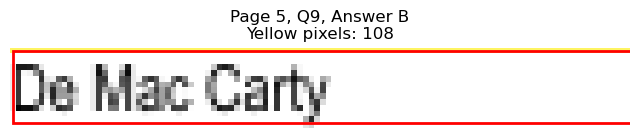

Page 5, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=372.7, y1=619.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 228
Page 5, Q9, C: Yellow percentage: 0.0%


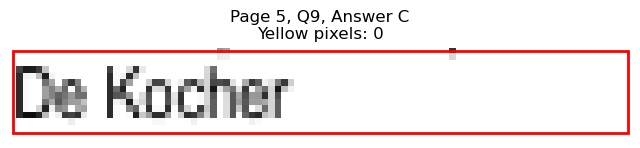

Page 5, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=365.2, y1=632.3
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 182
Page 5, Q9, D: Yellow percentage: 0.0%


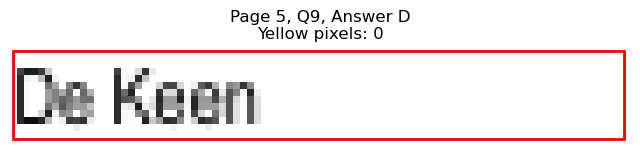


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=137.1, y1=682.7
Page 5, Q10, A: Yellow pixels: 1250
Page 5, Q10, A: Total non-white pixels: 1560
Page 5, Q10, A: Yellow percentage: 80.1%


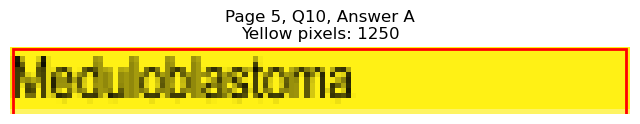

Page 5, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=132.0, y1=695.3
Page 5, Q10, B: Yellow pixels: 115
Page 5, Q10, B: Total non-white pixels: 456
Page 5, Q10, B: Yellow percentage: 25.2%


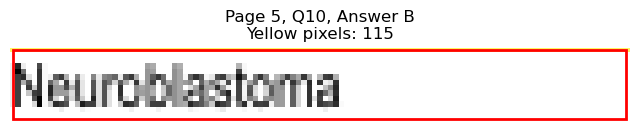

Page 5, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=377.7, y1=682.7
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 251
Page 5, Q10, C: Yellow percentage: 0.0%


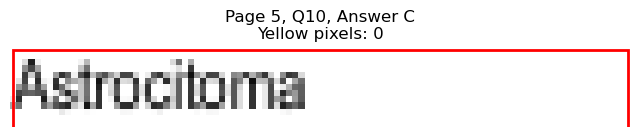

Page 5, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=405.8, y1=695.3
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 413
Page 5, Q10, D: Yellow percentage: 0.0%


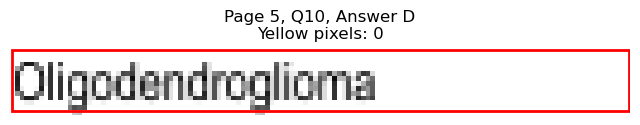


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=106.5, y1=733.2
Page 5, Q11, A: Yellow pixels: 1006
Page 5, Q11, A: Total non-white pixels: 1246
Page 5, Q11, A: Yellow percentage: 80.7%


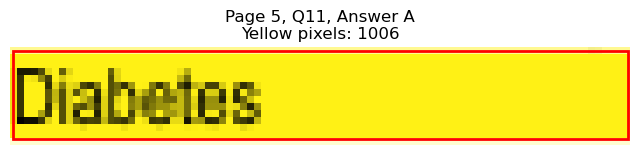

Page 5, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=113.9, y1=745.8
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 311
Page 5, Q11, B: Yellow percentage: 0.0%


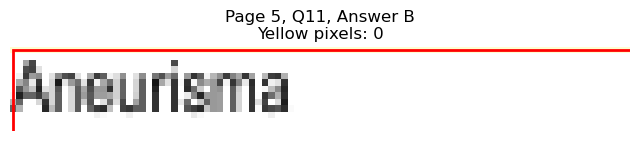

Page 5, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=370.1, y1=733.2
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 239
Page 5, Q11, C: Yellow percentage: 0.0%


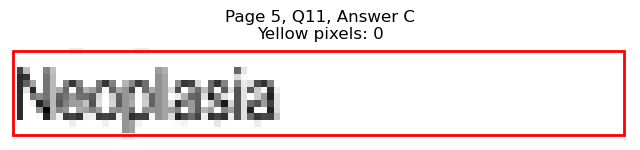

Page 5, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=374.2, y1=745.8
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 234
Page 5, Q11, D: Yellow percentage: 0.0%


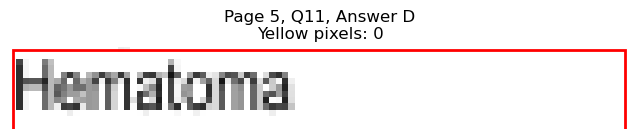


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=129.0, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 283
Page 6, Q1, A: Yellow percentage: 0.0%


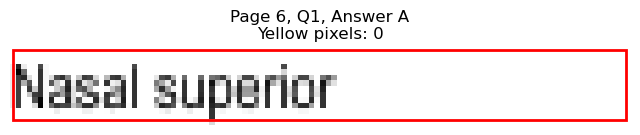

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=124.0, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 276
Page 6, Q1, B: Yellow percentage: 0.0%


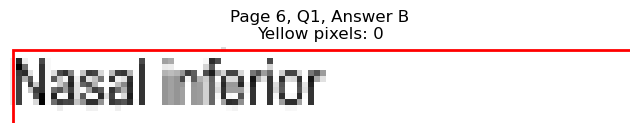

Page 6, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=398.2, y1=102.1
Page 6, Q1, C: Yellow pixels: 1323
Page 6, Q1, C: Total non-white pixels: 1708
Page 6, Q1, C: Yellow percentage: 77.5%


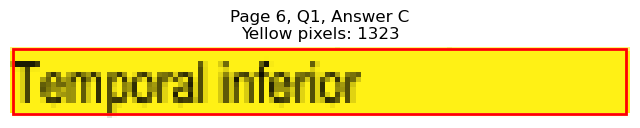

Page 6, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=403.3, y1=114.7
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 503
Page 6, Q1, D: Yellow percentage: 0.0%


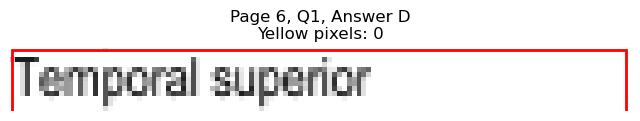


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=179.2, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 537
Page 6, Q2, A: Yellow percentage: 0.0%


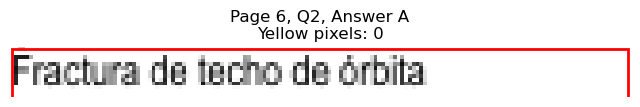

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=152.5, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 412
Page 6, Q2, B: Yellow percentage: 0.0%


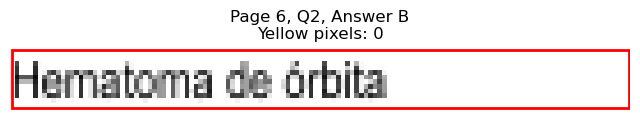

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=411.8, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 530
Page 6, Q2, C: Yellow percentage: 0.0%


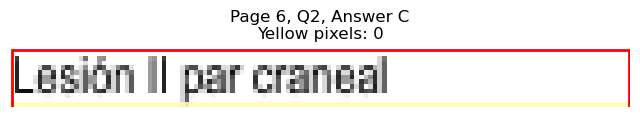

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=432.9, y1=190.4
Page 6, Q2, D: Yellow pixels: 1459
Page 6, Q2, D: Total non-white pixels: 2184
Page 6, Q2, D: Yellow percentage: 66.8%


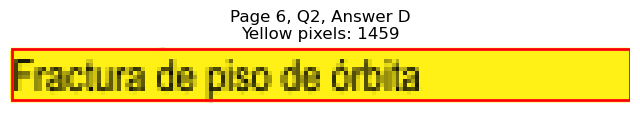


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=101.4, y1=228.3
Page 6, Q3, A: Yellow pixels: 887
Page 6, Q3, A: Total non-white pixels: 1176
Page 6, Q3, A: Yellow percentage: 75.4%


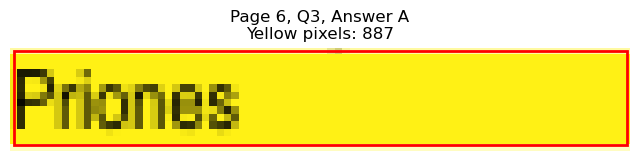

Page 6, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=104.9, y1=240.9
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 250
Page 6, Q3, B: Yellow percentage: 0.0%


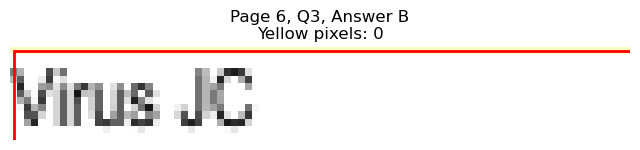

Page 6, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=345.1, y1=228.3
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 81
Page 6, Q3, C: Yellow percentage: 0.0%


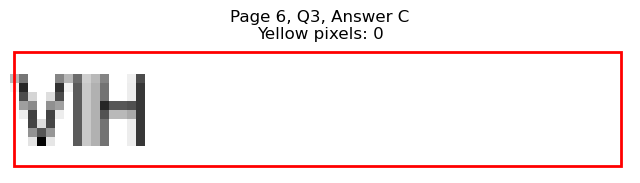

Page 6, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=424.3, y1=240.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 461
Page 6, Q3, D: Yellow percentage: 0.0%


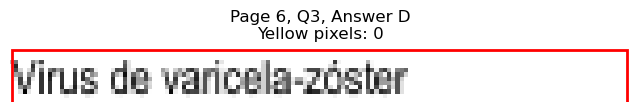


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=103.9, y1=278.7
Page 6, Q4, A: Yellow pixels: 975
Page 6, Q4, A: Total non-white pixels: 1118
Page 6, Q4, A: Yellow percentage: 87.2%


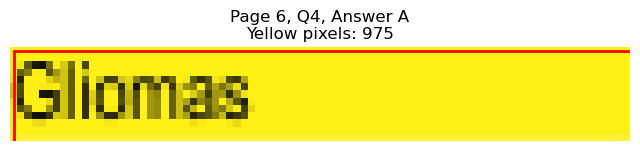

Page 6, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=113.9, y1=291.5
Page 6, Q4, B: Yellow pixels: 96
Page 6, Q4, B: Total non-white pixels: 364
Page 6, Q4, B: Yellow percentage: 26.4%


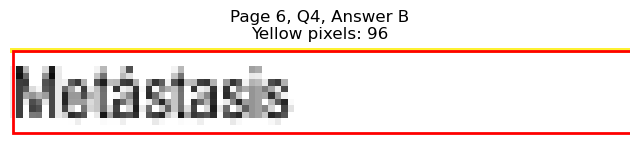

Page 6, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=384.2, y1=278.7
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 273
Page 6, Q4, C: Yellow percentage: 0.0%


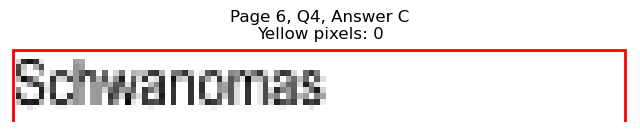

Page 6, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=389.2, y1=291.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 315
Page 6, Q4, D: Yellow percentage: 0.0%


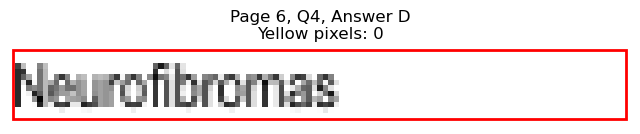


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=88.8, y1=329.3
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 95
Page 6, Q5, A: Yellow percentage: 0.0%


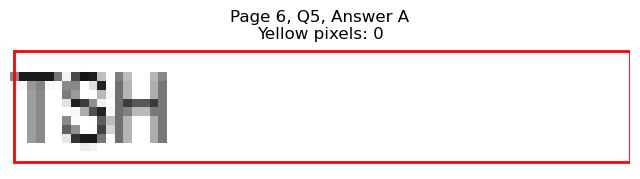

Page 6, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=103.3, y1=341.9
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 157
Page 6, Q5, B: Yellow percentage: 0.0%


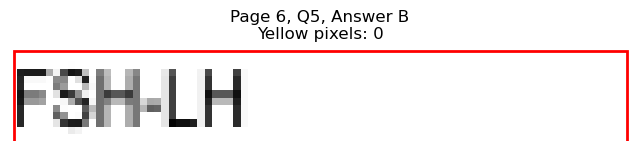

Page 6, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=343.6, y1=329.3
Page 6, Q5, C: Yellow pixels: 750
Page 6, Q5, C: Total non-white pixels: 938
Page 6, Q5, C: Yellow percentage: 80.0%


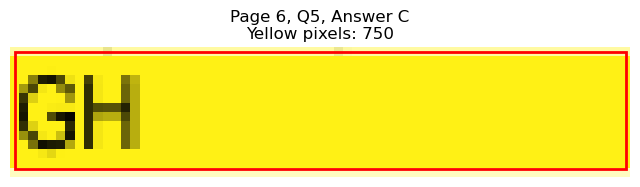

Page 6, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=354.7, y1=341.9
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 201
Page 6, Q5, D: Yellow percentage: 0.0%


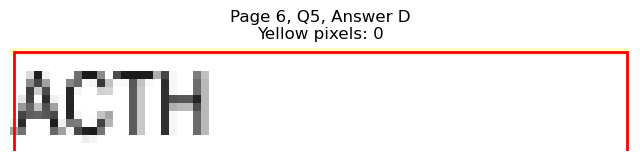


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=119.4, y1=379.8
Page 6, Q6, A: Yellow pixels: 1104
Page 6, Q6, A: Total non-white pixels: 1326
Page 6, Q6, A: Yellow percentage: 83.3%


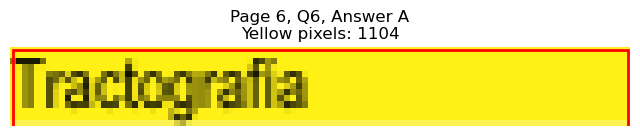

Page 6, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=109.9, y1=392.4
Page 6, Q6, B: Yellow pixels: 91
Page 6, Q6, B: Total non-white pixels: 272
Page 6, Q6, B: Yellow percentage: 33.5%


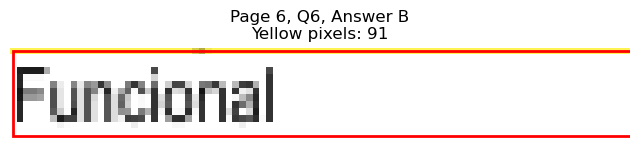

Page 6, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=368.2, y1=379.8
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 210
Page 6, Q6, C: Yellow percentage: 0.0%


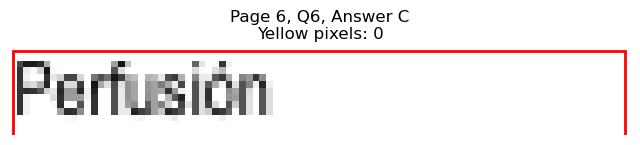

Page 6, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=392.2, y1=392.4
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 334
Page 6, Q6, D: Yellow percentage: 0.0%


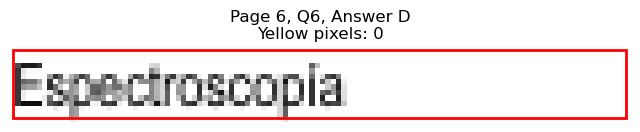


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=417.6, x1=116.4, y1=430.3
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 237
Page 6, Q7, A: Yellow percentage: 0.0%


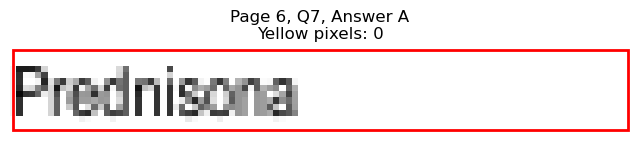

Page 6, Q7 - B: Detected box: x0=68.3, y0=430.2, x1=123.0, y1=442.9
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 264
Page 6, Q7, B: Yellow percentage: 0.0%


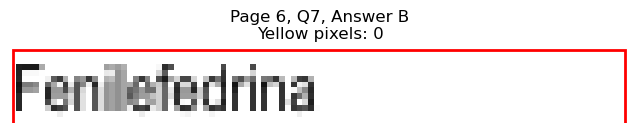

Page 6, Q7 - C: Detected box: x0=327.5, y0=417.6, x1=409.7, y1=430.3
Page 6, Q7, C: Yellow pixels: 1280
Page 6, Q7, C: Total non-white pixels: 1862
Page 6, Q7, C: Yellow percentage: 68.7%


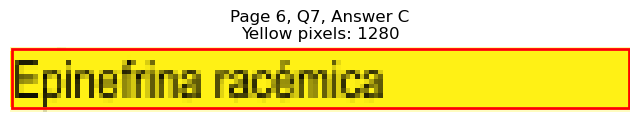

Page 6, Q7 - D: Detected box: x0=327.5, y0=430.2, x1=391.3, y1=442.9
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 457
Page 6, Q7, D: Yellow percentage: 0.0%


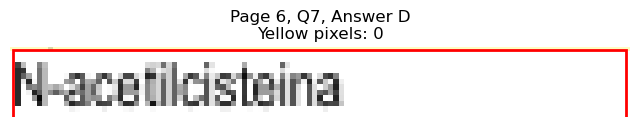


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=493.4, x1=222.3, y1=506.0
Page 6, Q8, A: Yellow pixels: 2037
Page 6, Q8, A: Total non-white pixels: 2668
Page 6, Q8, A: Yellow percentage: 76.3%


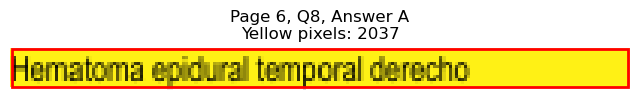

Page 6, Q8 - B: Detected box: x0=68.3, y0=506.0, x1=176.2, y1=518.6
Page 6, Q8, B: Yellow pixels: 156
Page 6, Q8, B: Total non-white pixels: 709
Page 6, Q8, B: Yellow percentage: 22.0%


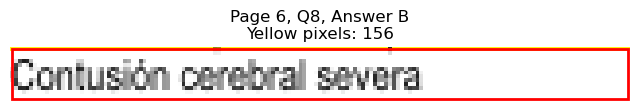

Page 6, Q8 - C: Detected box: x0=68.8, y0=518.6, x1=158.5, y1=531.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 446
Page 6, Q8, C: Yellow percentage: 0.0%


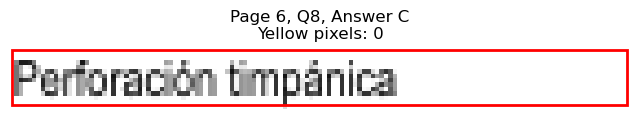

Page 6, Q8 - D: Detected box: x0=68.8, y0=531.2, x1=290.1, y1=543.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 1040
Page 6, Q8, D: Yellow percentage: 0.0%


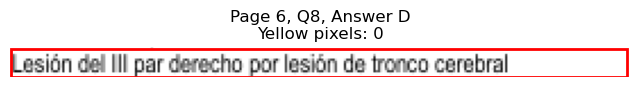


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=569.1, x1=186.6, y1=581.8
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 711
Page 6, Q9, A: Yellow percentage: 0.0%


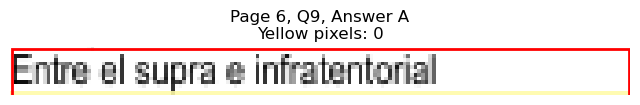

Page 6, Q9 - B: Detected box: x0=68.3, y0=581.7, x1=201.6, y1=594.4
Page 6, Q9, B: Yellow pixels: 1722
Page 6, Q9, B: Total non-white pixels: 2576
Page 6, Q9, B: Yellow percentage: 66.8%


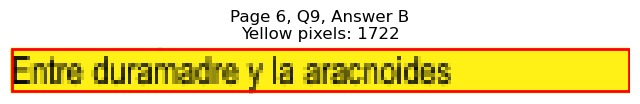

Page 6, Q9 - C: Detected box: x0=327.5, y0=569.1, x1=450.9, y1=581.8
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 585
Page 6, Q9, C: Yellow percentage: 0.0%


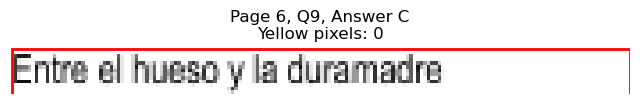

Page 6, Q9 - D: Detected box: x0=327.5, y0=581.7, x1=445.9, y1=594.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 577
Page 6, Q9, D: Yellow percentage: 0.0%


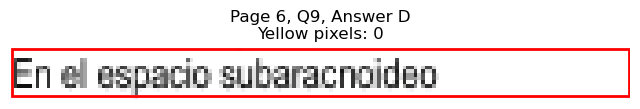


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=79.3, y1=644.9
Page 6, Q10, A: Yellow pixels: 775
Page 6, Q10, A: Total non-white pixels: 806
Page 6, Q10, A: Yellow percentage: 96.2%


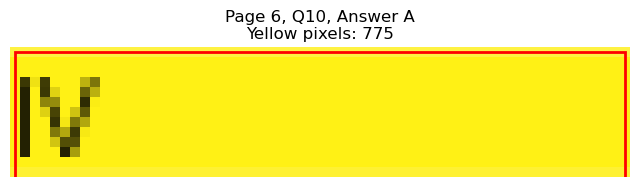

Page 6, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=78.4, y1=657.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 32
Page 6, Q10, B: Yellow percentage: 0.0%


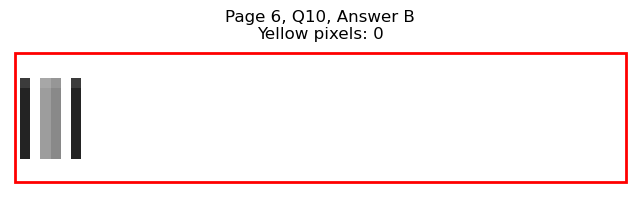

Page 6, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=324.4, y1=644.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 68
Page 6, Q10, C: Yellow percentage: 0.0%


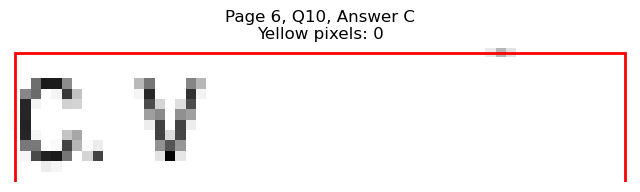

Page 6, Q10 - D: Detected box: x0=315.4, y0=644.9, x1=324.4, y1=657.5
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 72
Page 6, Q10, D: Yellow percentage: 0.0%


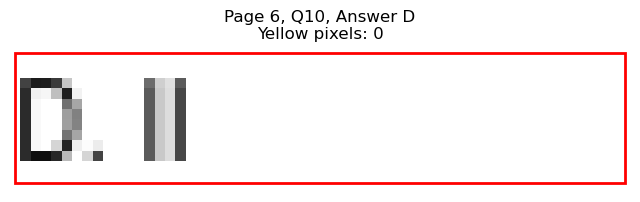


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=184.1, y1=695.3
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 571
Page 6, Q11, A: Yellow percentage: 0.0%


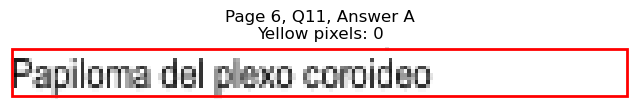

Page 6, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=124.0, y1=708.0
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 279
Page 6, Q11, B: Yellow percentage: 0.0%


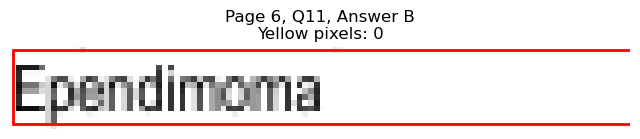

Page 6, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=377.7, y1=695.3
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 254
Page 6, Q11, C: Yellow percentage: 0.0%


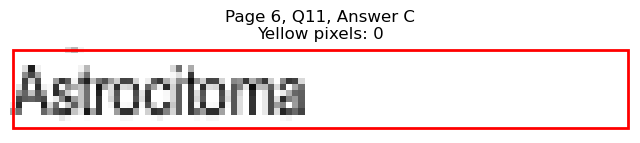

Page 6, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=405.8, y1=708.0
Page 6, Q11, D: Yellow pixels: 1389
Page 6, Q11, D: Total non-white pixels: 1681
Page 6, Q11, D: Yellow percentage: 82.6%


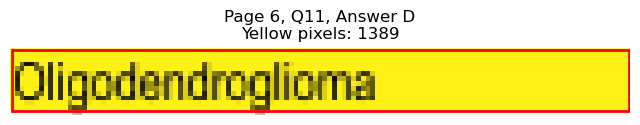


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=733.2, x1=121.9, y1=745.8
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 241
Page 6, Q12, A: Yellow percentage: 0.0%


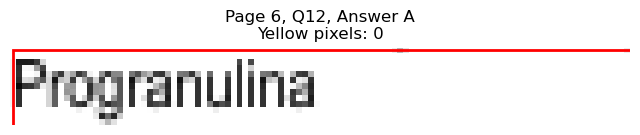

Page 6, Q12 - B: Detected box: x0=68.3, y0=745.8, x1=129.5, y1=758.4
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 314
Page 6, Q12, B: Yellow percentage: 0.0%


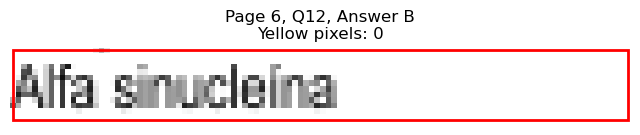

Page 6, Q12 - C: Detected box: x0=327.5, y0=733.2, x1=345.7, y1=745.8
Page 6, Q12, C: Yellow pixels: 0
Page 6, Q12, C: Total non-white pixels: 147
Page 6, Q12, C: Yellow percentage: 0.0%


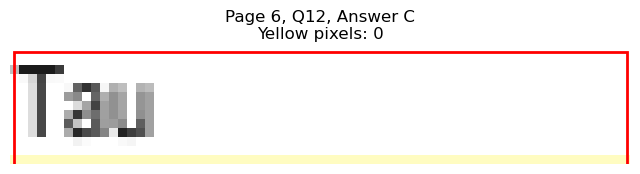

Page 6, Q12 - D: Detected box: x0=327.5, y0=745.8, x1=422.4, y1=758.4
Page 6, Q12, D: Yellow pixels: 1507
Page 6, Q12, D: Total non-white pixels: 2044
Page 6, Q12, D: Yellow percentage: 73.7%


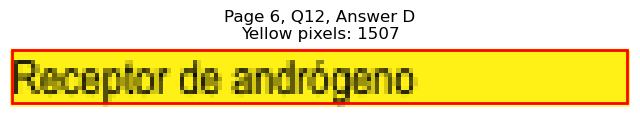


Page 6, Q12 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=94.9, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 122
Page 7, Q1, A: Yellow percentage: 0.0%


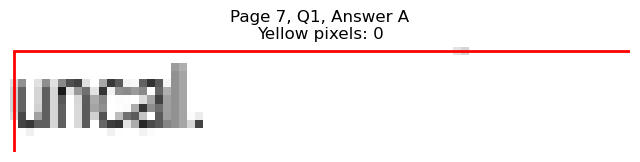

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=125.5, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 277
Page 7, Q1, B: Yellow percentage: 0.0%


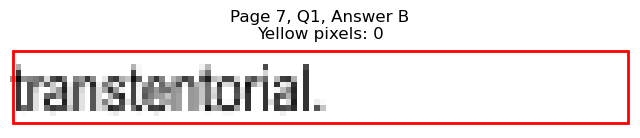

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=381.2, y1=114.7
Page 7, Q1, C: Yellow pixels: 3
Page 7, Q1, C: Total non-white pixels: 391
Page 7, Q1, C: Yellow percentage: 0.8%


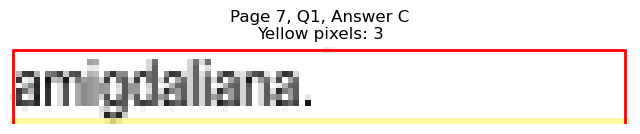

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=373.1, y1=127.3
Page 7, Q1, D: Yellow pixels: 989
Page 7, Q1, D: Total non-white pixels: 1358
Page 7, Q1, D: Yellow percentage: 72.8%


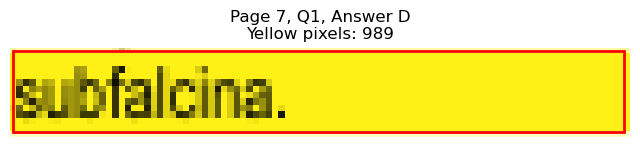


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=107.9, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 203
Page 7, Q2, A: Yellow percentage: 0.0%


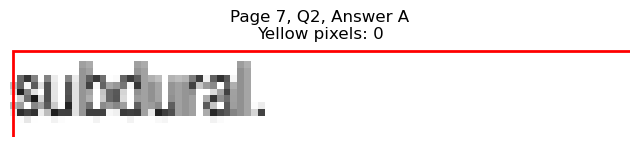

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=118.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 250
Page 7, Q2, B: Yellow percentage: 0.0%


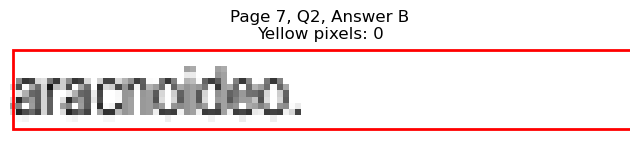

Page 7, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=382.3, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 376
Page 7, Q2, C: Yellow percentage: 0.0%


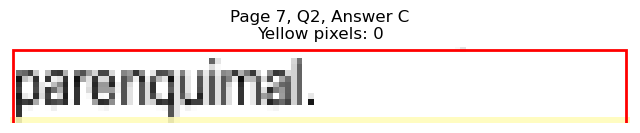

Page 7, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=364.6, y1=190.4
Page 7, Q2, D: Yellow pixels: 937
Page 7, Q2, D: Total non-white pixels: 1232
Page 7, Q2, D: Yellow percentage: 76.1%


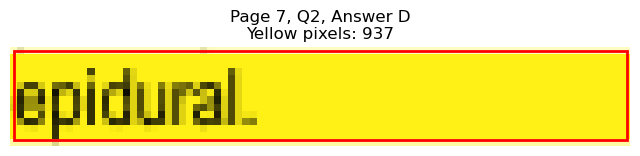


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=130.0, y1=253.5
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 313
Page 7, Q3, A: Yellow percentage: 0.0%


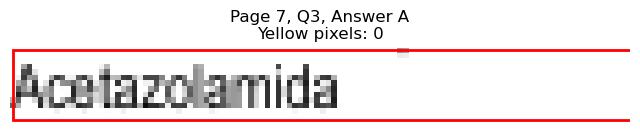

Page 7, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=111.4, y1=266.1
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 211
Page 7, Q3, B: Yellow percentage: 0.0%


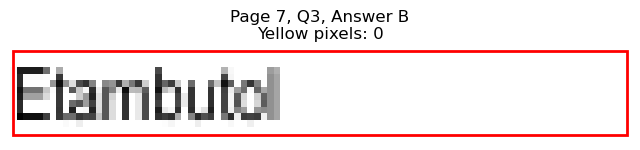

Page 7, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=376.1, y1=253.5
Page 7, Q3, C: Yellow pixels: 1124
Page 7, Q3, C: Total non-white pixels: 1400
Page 7, Q3, C: Yellow percentage: 80.3%


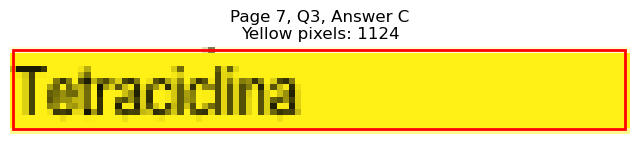

Page 7, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=362.1, y1=266.1
Page 7, Q3, D: Yellow pixels: 86
Page 7, Q3, D: Total non-white pixels: 256
Page 7, Q3, D: Yellow percentage: 33.6%


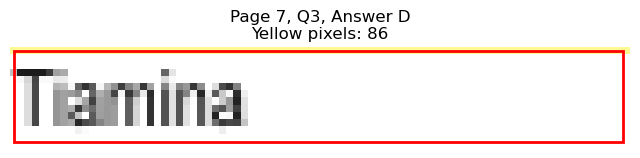


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=163.1, y1=316.7
Page 7, Q4, A: Yellow pixels: 1511
Page 7, Q4, A: Total non-white pixels: 1898
Page 7, Q4, A: Yellow percentage: 79.6%


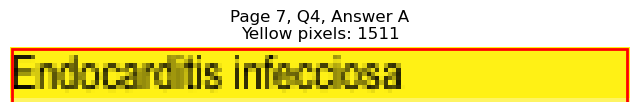

Page 7, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=141.0, y1=329.3
Page 7, Q4, B: Yellow pixels: 124
Page 7, Q4, B: Total non-white pixels: 519
Page 7, Q4, B: Yellow percentage: 23.9%


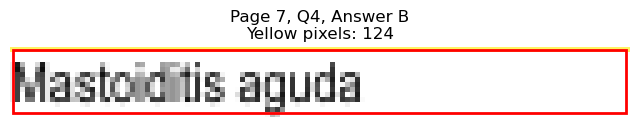

Page 7, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=457.0, y1=316.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 658
Page 7, Q4, C: Yellow percentage: 0.0%


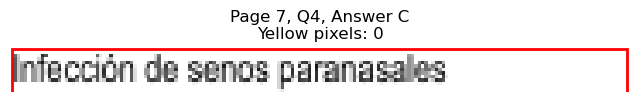

Page 7, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=398.8, y1=329.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 369
Page 7, Q4, D: Yellow percentage: 0.0%


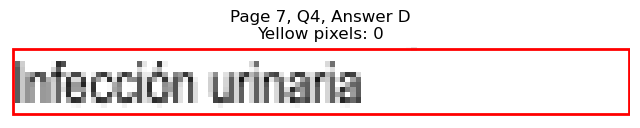


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=159.6, y1=379.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 495
Page 7, Q5, A: Yellow percentage: 0.0%


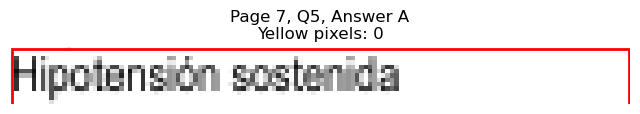

Page 7, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=99.9, y1=392.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 178
Page 7, Q5, B: Yellow percentage: 0.0%


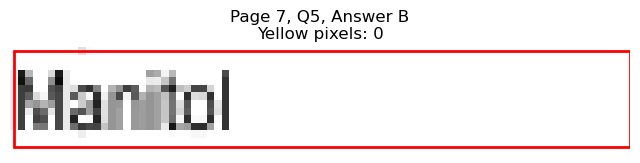

Page 7, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=361.6, y1=379.8
Page 7, Q5, C: Yellow pixels: 961
Page 7, Q5, C: Total non-white pixels: 1105
Page 7, Q5, C: Yellow percentage: 87.0%


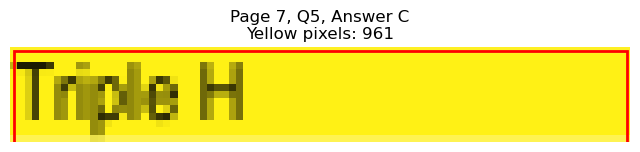

Page 7, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=392.2, y1=392.4
Page 7, Q5, D: Yellow pixels: 116
Page 7, Q5, D: Total non-white pixels: 439
Page 7, Q5, D: Yellow percentage: 26.4%


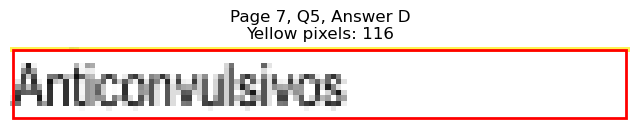


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=182.7, y1=442.9
Page 7, Q6, A: Yellow pixels: 1696
Page 7, Q6, A: Total non-white pixels: 2145
Page 7, Q6, A: Yellow percentage: 79.1%


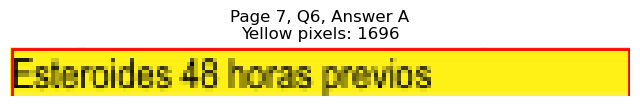

Page 7, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=244.4, y1=455.5
Page 7, Q6, B: Yellow pixels: 211
Page 7, Q6, B: Total non-white pixels: 1057
Page 7, Q6, B: Yellow percentage: 20.0%


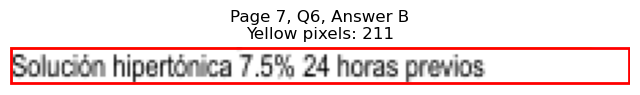

Page 7, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=428.3, y1=442.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 493
Page 7, Q6, C: Yellow percentage: 0.0%


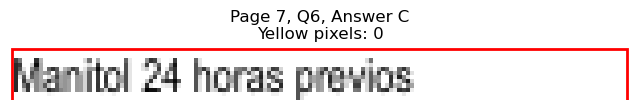

Page 7, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=470.5, y1=455.5
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 707
Page 7, Q6, D: Yellow percentage: 0.0%


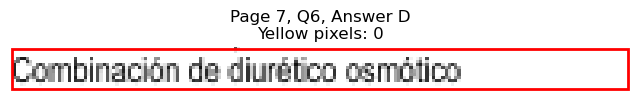


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=214.8, y1=493.4
Page 7, Q7, A: Yellow pixels: 197
Page 7, Q7, A: Total non-white pixels: 932
Page 7, Q7, A: Yellow percentage: 21.1%


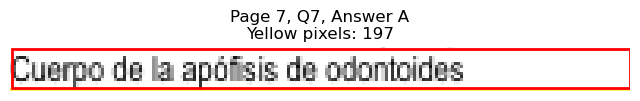

Page 7, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=132.5, y1=506.0
Page 7, Q7, B: Yellow pixels: 1263
Page 7, Q7, B: Total non-white pixels: 1495
Page 7, Q7, B: Yellow percentage: 84.5%


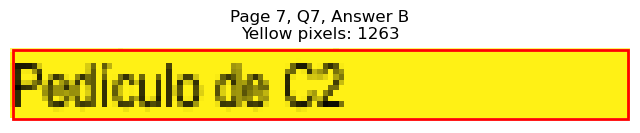

Page 7, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=468.1, y1=493.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 698
Page 7, Q7, C: Yellow percentage: 0.0%


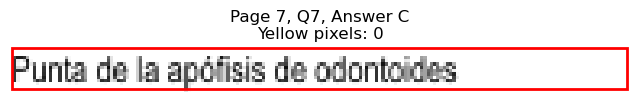

Page 7, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=391.7, y1=506.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 313
Page 7, Q7, D: Yellow percentage: 0.0%


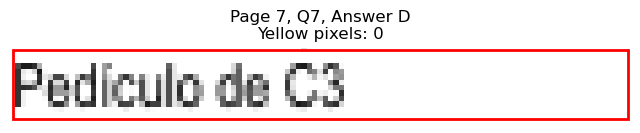


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=207.3, y1=543.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 862
Page 7, Q8, A: Yellow percentage: 0.0%


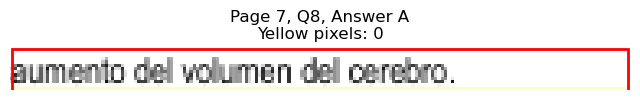

Page 7, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=241.8, y1=556.4
Page 7, Q8, B: Yellow pixels: 2130
Page 7, Q8, B: Total non-white pixels: 2996
Page 7, Q8, B: Yellow percentage: 71.1%


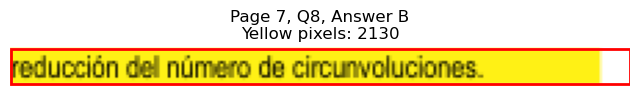

Page 7, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=479.0, y1=543.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 726
Page 7, Q8, C: Yellow percentage: 0.0%


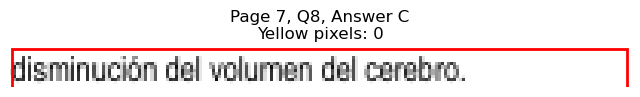

Page 7, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=541.2, y1=556.4
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 1013
Page 7, Q8, D: Yellow percentage: 0.0%


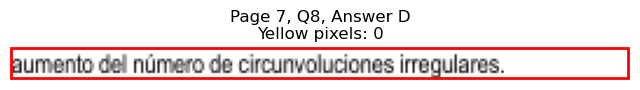


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=121.0, y1=594.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 235
Page 7, Q9, A: Yellow percentage: 0.0%


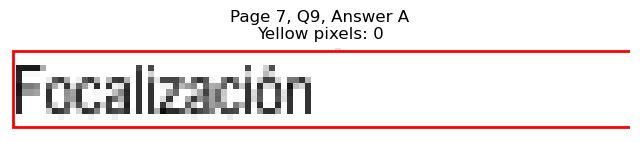

Page 7, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=124.9, y1=607.0
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 273
Page 7, Q9, B: Yellow percentage: 0.0%


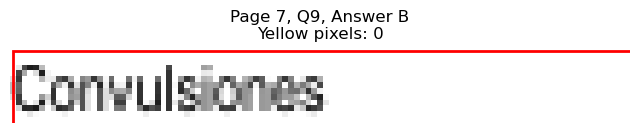

Page 7, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=379.3, y1=594.4
Page 7, Q9, C: Yellow pixels: 1040
Page 7, Q9, C: Total non-white pixels: 1442
Page 7, Q9, C: Yellow percentage: 72.1%


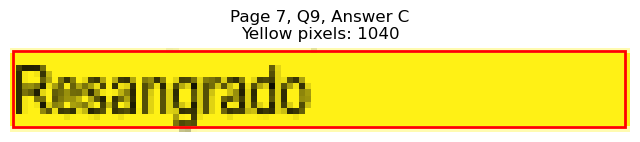

Page 7, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=355.6, y1=607.0
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 224
Page 7, Q9, D: Yellow percentage: 0.0%


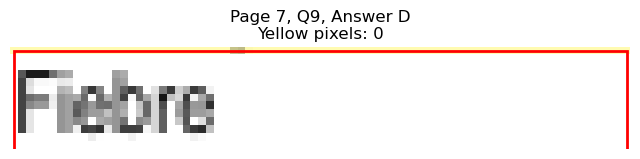


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=222.8, y1=644.9
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 769
Page 7, Q10, A: Yellow percentage: 0.0%


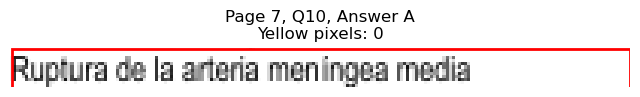

Page 7, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=187.7, y1=657.5
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 619
Page 7, Q10, B: Yellow percentage: 0.0%


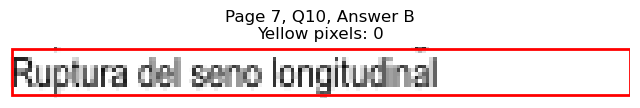

Page 7, Q10 - C: Detected box: x0=68.8, y0=657.5, x1=292.0, y1=670.1
Page 7, Q10, C: Yellow pixels: 275
Page 7, Q10, C: Total non-white pixels: 1368
Page 7, Q10, C: Yellow percentage: 20.1%


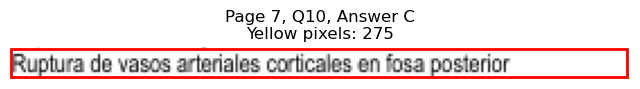

Page 7, Q10 - D: Detected box: x0=68.8, y0=670.1, x1=321.0, y1=682.7
Page 7, Q10, D: Yellow pixels: 3025
Page 7, Q10, D: Total non-white pixels: 3952
Page 7, Q10, D: Yellow percentage: 76.5%


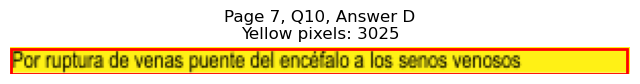


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=150.5, y1=720.6
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 446
Page 7, Q11, A: Yellow percentage: 0.0%


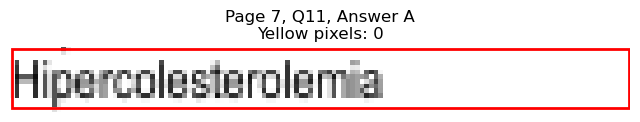

Page 7, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=116.4, y1=733.2
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 258
Page 7, Q11, B: Yellow percentage: 0.0%


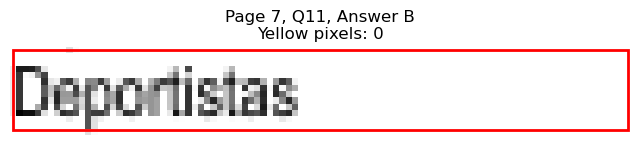

Page 7, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=429.9, y1=720.6
Page 7, Q11, C: Yellow pixels: 1584
Page 7, Q11, C: Total non-white pixels: 2142
Page 7, Q11, C: Yellow percentage: 73.9%


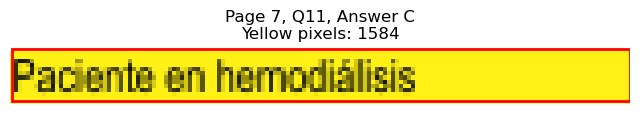

Page 7, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=394.7, y1=733.2
Page 7, Q11, D: Yellow pixels: 118
Page 7, Q11, D: Total non-white pixels: 434
Page 7, Q11, D: Yellow percentage: 27.2%


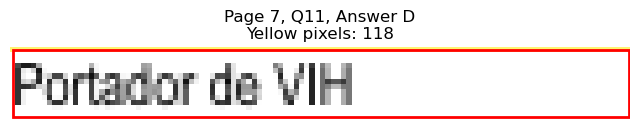


Page 7, Q11 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=168.1, y1=102.1
Page 8, Q1, A: Yellow pixels: 151
Page 8, Q1, A: Total non-white pixels: 661
Page 8, Q1, A: Yellow percentage: 22.8%


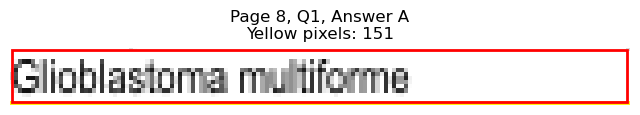

Page 8, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=174.1, y1=114.7
Page 8, Q1, B: Yellow pixels: 1618
Page 8, Q1, B: Total non-white pixels: 2041
Page 8, Q1, B: Yellow percentage: 79.3%


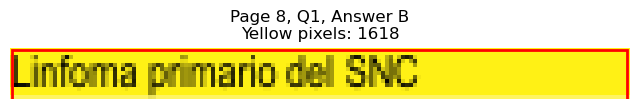

Page 8, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=407.8, y1=102.1
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 413
Page 8, Q1, C: Yellow percentage: 0.0%


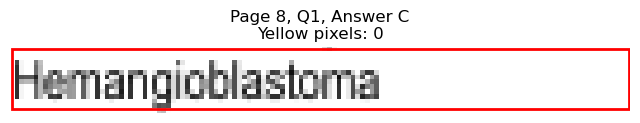

Page 8, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=396.3, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 382
Page 8, Q1, D: Yellow percentage: 0.0%


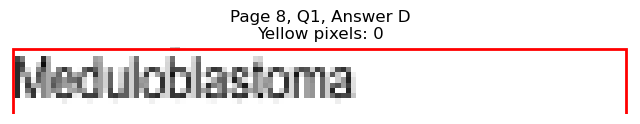


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=158.1, y1=152.6
Page 8, Q2, A: Yellow pixels: 141
Page 8, Q2, A: Total non-white pixels: 573
Page 8, Q2, A: Yellow percentage: 24.6%


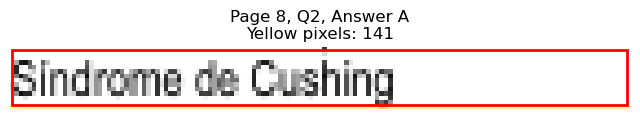

Page 8, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=123.5, y1=165.2
Page 8, Q2, B: Yellow pixels: 1189
Page 8, Q2, B: Total non-white pixels: 1484
Page 8, Q2, B: Yellow percentage: 80.1%


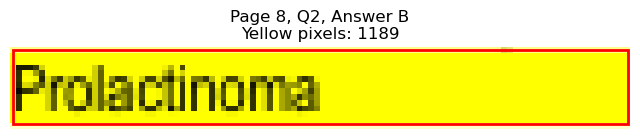

Page 8, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=375.7, y1=152.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 247
Page 8, Q2, C: Yellow percentage: 0.0%


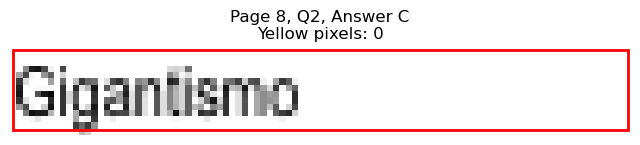

Page 8, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=380.2, y1=165.2
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 284
Page 8, Q2, D: Yellow percentage: 0.0%


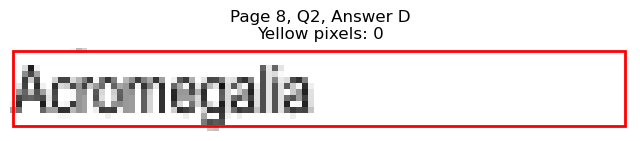


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=254.8, y1=203.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 1129
Page 8, Q3, A: Yellow percentage: 0.0%


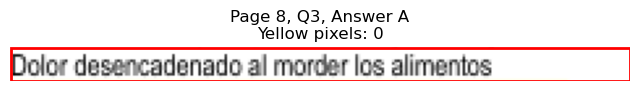

Page 8, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=245.9, y1=215.6
Page 8, Q3, B: Yellow pixels: 2132
Page 8, Q3, B: Total non-white pixels: 2996
Page 8, Q3, B: Yellow percentage: 71.2%


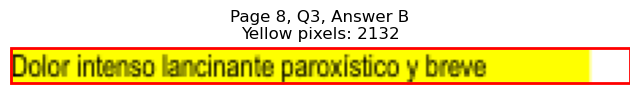

Page 8, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=481.7, y1=203.0
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 770
Page 8, Q3, C: Yellow percentage: 0.0%


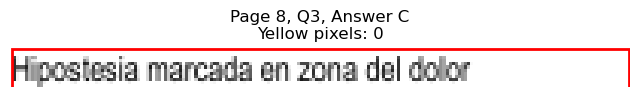

Page 8, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=443.9, y1=215.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 594
Page 8, Q3, D: Yellow percentage: 0.0%


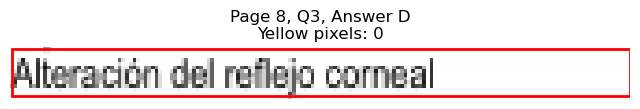


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=174.1, y1=291.5
Page 8, Q4, A: Yellow pixels: 1642
Page 8, Q4, A: Total non-white pixels: 2198
Page 8, Q4, A: Yellow percentage: 74.7%


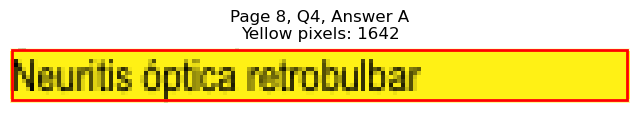

Page 8, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=146.1, y1=304.1
Page 8, Q4, B: Yellow pixels: 129
Page 8, Q4, B: Total non-white pixels: 521
Page 8, Q4, B: Yellow percentage: 24.8%


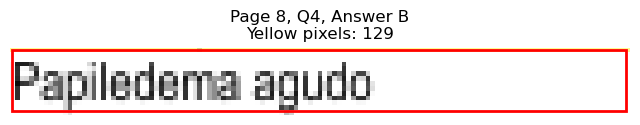

Page 8, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=482.1, y1=291.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 813
Page 8, Q4, C: Yellow percentage: 0.0%


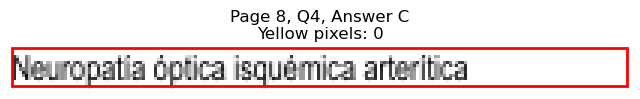

Page 8, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=494.6, y1=304.1
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 863
Page 8, Q4, D: Yellow percentage: 0.0%


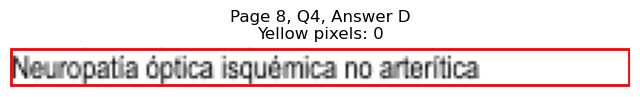


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=95.9, y1=341.9
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 142
Page 8, Q5, A: Yellow percentage: 0.0%


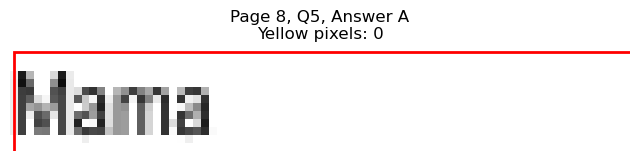

Page 8, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=112.9, y1=354.6
Page 8, Q5, B: Yellow pixels: 1045
Page 8, Q5, B: Total non-white pixels: 1330
Page 8, Q5, B: Yellow percentage: 78.6%


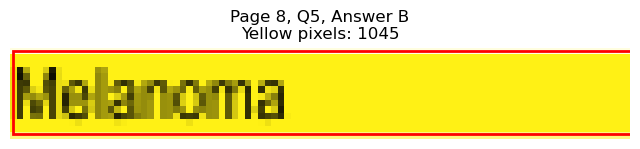

Page 8, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=360.7, y1=341.9
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 143
Page 8, Q5, C: Yellow percentage: 0.0%


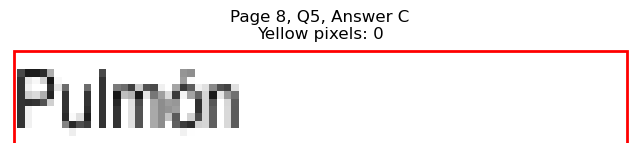

Page 8, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=363.7, y1=354.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 189
Page 8, Q5, D: Yellow percentage: 0.0%


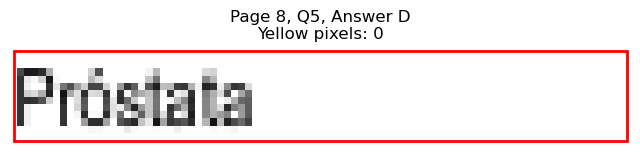


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=267.9, y1=392.4
Page 8, Q6, A: Yellow pixels: 4
Page 8, Q6, A: Total non-white pixels: 1011
Page 8, Q6, A: Yellow percentage: 0.4%


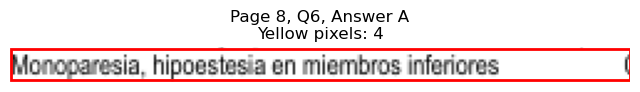

Page 8, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=215.7, y1=405.0
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 740
Page 8, Q6, B: Yellow percentage: 0.0%


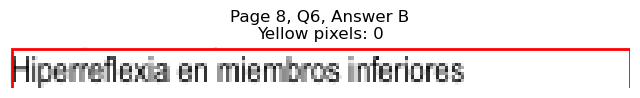

Page 8, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=393.2, y1=392.4
Page 8, Q6, C: Yellow pixels: 117
Page 8, Q6, C: Total non-white pixels: 428
Page 8, Q6, C: Yellow percentage: 27.3%


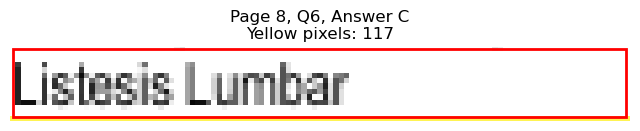

Page 8, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=480.6, y1=405.0
Page 8, Q6, D: Yellow pixels: 2038
Page 8, Q6, D: Total non-white pixels: 2652
Page 8, Q6, D: Yellow percentage: 76.8%


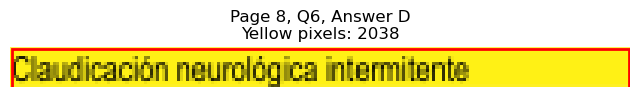


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=119.9, y1=442.9
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 286
Page 8, Q7, A: Yellow percentage: 0.0%


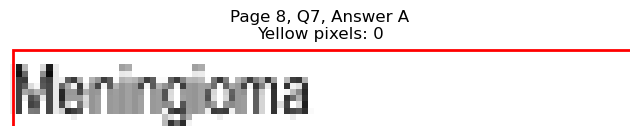

Page 8, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=114.4, y1=455.5
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 225
Page 8, Q7, B: Yellow percentage: 0.0%


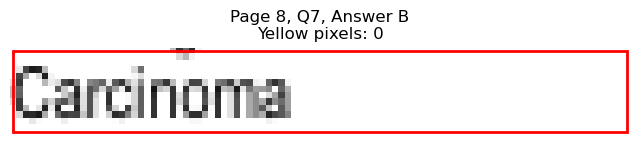

Page 8, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=356.1, y1=442.9
Page 8, Q7, C: Yellow pixels: 944
Page 8, Q7, C: Total non-white pixels: 1040
Page 8, Q7, C: Yellow percentage: 90.8%


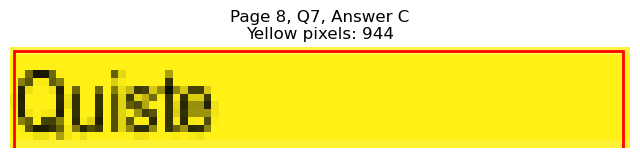

Page 8, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=359.7, y1=455.5
Page 8, Q7, D: Yellow pixels: 83
Page 8, Q7, D: Total non-white pixels: 215
Page 8, Q7, D: Yellow percentage: 38.6%


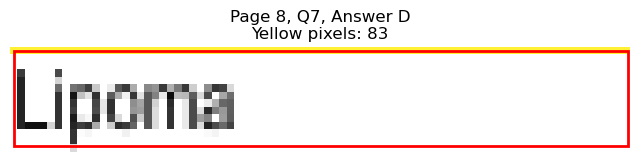


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=210.8, y1=493.4
Page 8, Q8, A: Yellow pixels: 193
Page 8, Q8, A: Total non-white pixels: 942
Page 8, Q8, A: Yellow percentage: 20.5%


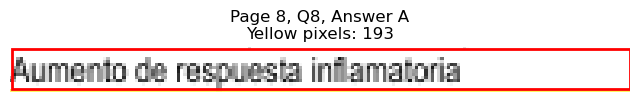

Page 8, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=327.2, y1=506.0
Page 8, Q8, B: Yellow pixels: 3002
Page 8, Q8, B: Total non-white pixels: 4030
Page 8, Q8, B: Yellow percentage: 74.5%


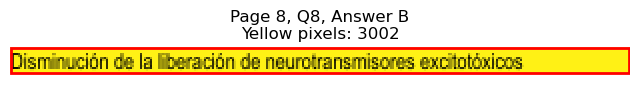

Page 8, Q8 - C: Detected box: x0=68.8, y0=506.0, x1=315.6, y1=518.6
Page 8, Q8, C: Yellow pixels: 298
Page 8, Q8, C: Total non-white pixels: 1533
Page 8, Q8, C: Yellow percentage: 19.4%


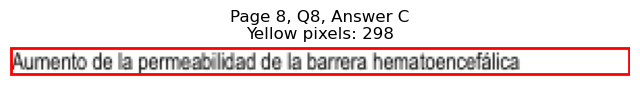

Page 8, Q8 - D: Detected box: x0=68.8, y0=518.6, x1=201.8, y1=531.2
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 659
Page 8, Q8, D: Yellow percentage: 0.0%


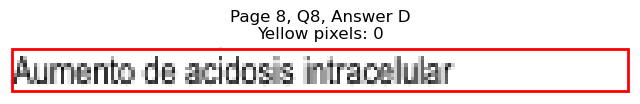


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=372.7, y1=569.2
Page 8, Q9, A: Yellow pixels: 3464
Page 8, Q9, A: Total non-white pixels: 4970
Page 8, Q9, A: Yellow percentage: 69.7%


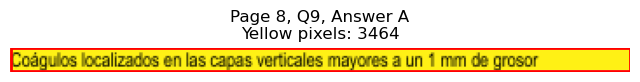

Page 8, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=250.8, y1=581.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 1127
Page 8, Q9, B: Yellow percentage: 0.0%


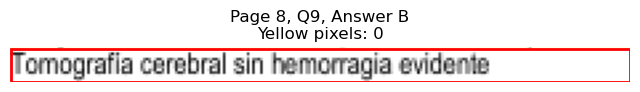

Page 8, Q9 - C: Detected box: x0=68.8, y0=581.7, x1=414.3, y1=594.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 1671
Page 8, Q9, C: Yellow percentage: 0.0%


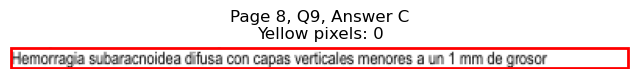

Page 8, Q9 - D: Detected box: x0=68.8, y0=594.3, x1=296.4, y1=607.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 1168
Page 8, Q9, D: Yellow percentage: 0.0%


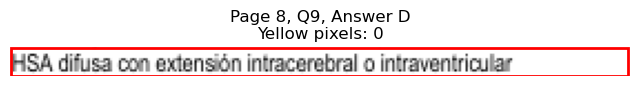


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=160.1, y1=644.9
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 459
Page 8, Q10, A: Yellow percentage: 0.0%


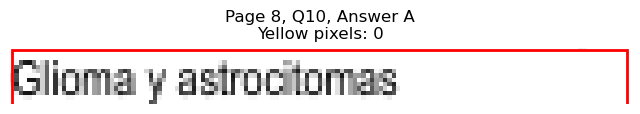

Page 8, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=196.7, y1=657.5
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 667
Page 8, Q10, B: Yellow percentage: 0.0%


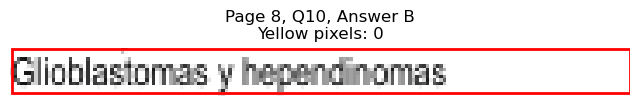

Page 8, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=433.9, y1=644.9
Page 8, Q10, C: Yellow pixels: 1600
Page 8, Q10, C: Total non-white pixels: 2041
Page 8, Q10, C: Yellow percentage: 78.4%


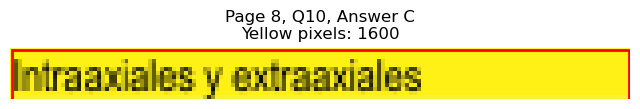

Page 8, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=483.0, y1=657.5
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 778
Page 8, Q10, D: Yellow percentage: 0.0%


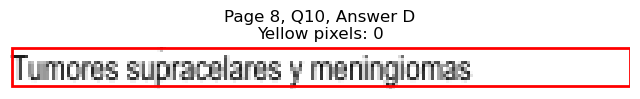


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=91.3, y1=695.3
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 111
Page 8, Q11, A: Yellow percentage: 0.0%


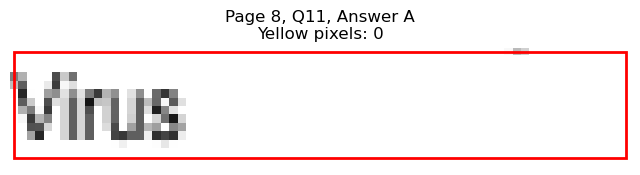

Page 8, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=101.4, y1=708.0
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 170
Page 8, Q11, B: Yellow percentage: 0.0%


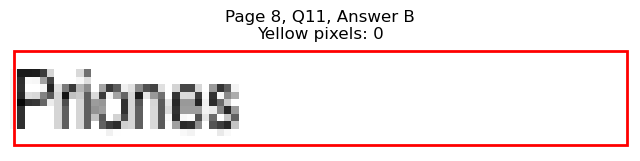

Page 8, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=367.6, y1=695.3
Page 8, Q11, C: Yellow pixels: 935
Page 8, Q11, C: Total non-white pixels: 1274
Page 8, Q11, C: Yellow percentage: 73.4%


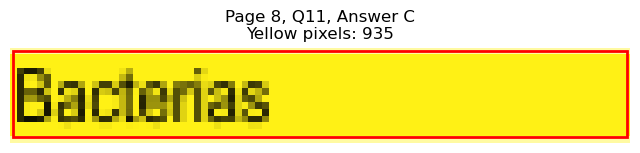

Page 8, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=365.2, y1=708.0
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 288
Page 8, Q11, D: Yellow percentage: 0.0%


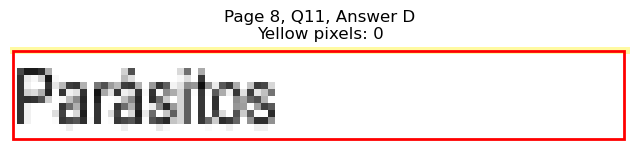


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=120.0, y1=127.3
Page 9, Q1, A: Yellow pixels: 103
Page 9, Q1, A: Total non-white pixels: 383
Page 9, Q1, A: Yellow percentage: 26.9%


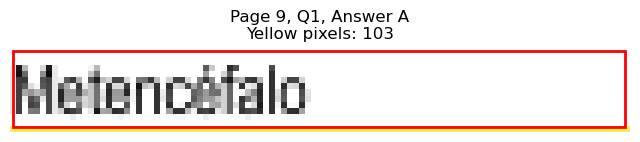

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=113.4, y1=139.9
Page 9, Q1, B: Yellow pixels: 1068
Page 9, Q1, B: Total non-white pixels: 1248
Page 9, Q1, B: Yellow percentage: 85.6%


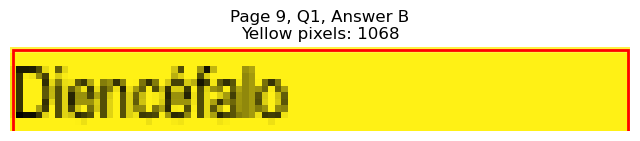

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=376.7, y1=127.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 260
Page 9, Q1, C: Yellow percentage: 0.0%


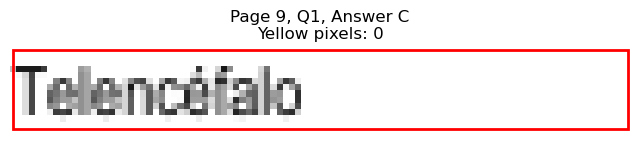

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=380.7, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 299
Page 9, Q1, D: Yellow percentage: 0.0%


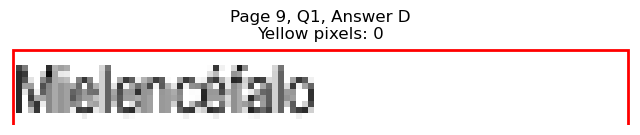


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=103.5, y1=177.8
Page 9, Q2, A: Yellow pixels: 968
Page 9, Q2, A: Total non-white pixels: 1118
Page 9, Q2, A: Yellow percentage: 86.6%


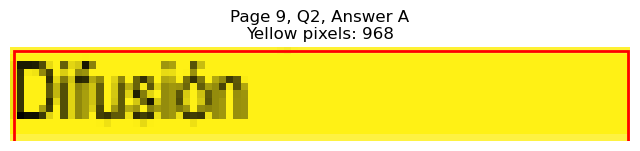

Page 9, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=109.0, y1=190.4
Page 9, Q2, B: Yellow pixels: 91
Page 9, Q2, B: Total non-white pixels: 290
Page 9, Q2, B: Yellow percentage: 31.4%


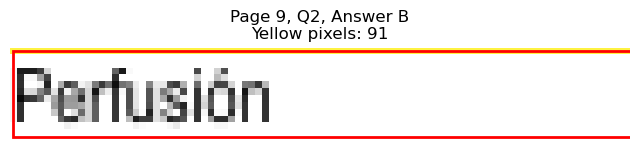

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=392.2, y1=177.8
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 336
Page 9, Q2, C: Yellow percentage: 0.0%


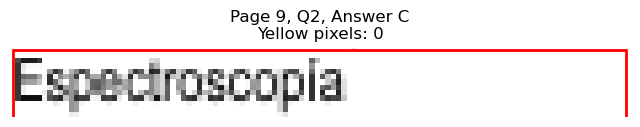

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=378.7, y1=190.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 271
Page 9, Q2, D: Yellow percentage: 0.0%


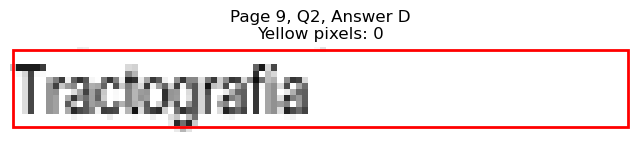


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=78.4, y1=240.9
Page 9, Q3, A: Yellow pixels: 761
Page 9, Q3, A: Total non-white pixels: 793
Page 9, Q3, A: Yellow percentage: 96.0%


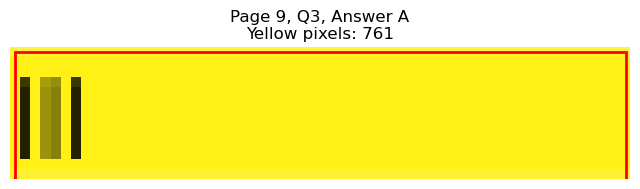

Page 9, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=79.3, y1=253.5
Page 9, Q3, B: Yellow pixels: 62
Page 9, Q3, B: Total non-white pixels: 98
Page 9, Q3, B: Yellow percentage: 63.3%


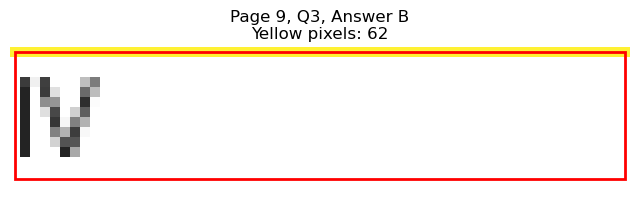

Page 9, Q3 - C: Detected box: x0=315.4, y0=228.3, x1=324.4, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 71
Page 9, Q3, C: Yellow percentage: 0.0%


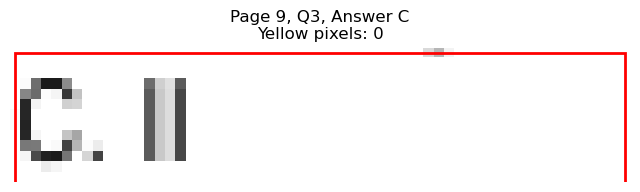

Page 9, Q3 - D: Detected box: x0=315.4, y0=240.9, x1=324.4, y1=253.5
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 69
Page 9, Q3, D: Yellow percentage: 0.0%


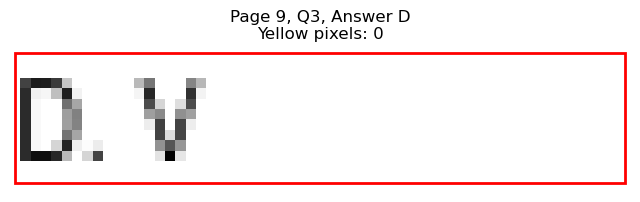


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=180.1, y1=304.1
Page 9, Q4, A: Yellow pixels: 1670
Page 9, Q4, A: Total non-white pixels: 2282
Page 9, Q4, A: Yellow percentage: 73.2%


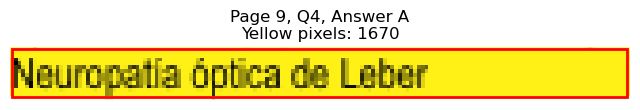

Page 9, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=181.1, y1=316.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 741
Page 9, Q4, B: Yellow percentage: 0.0%


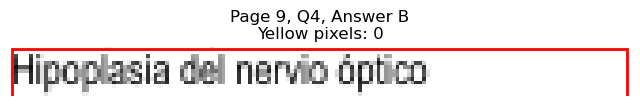

Page 9, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=476.0, y1=304.1
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 762
Page 9, Q4, C: Yellow percentage: 0.0%


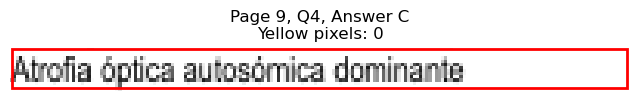

Page 9, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=444.4, y1=316.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 623
Page 9, Q4, D: Yellow percentage: 0.0%


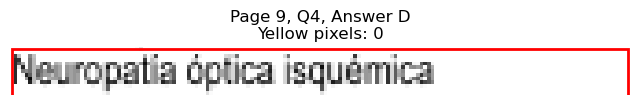


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=134.1, y1=367.2
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 337
Page 9, Q5, A: Yellow percentage: 0.0%


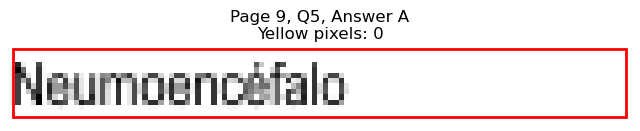

Page 9, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=114.4, y1=379.8
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 245
Page 9, Q5, B: Yellow percentage: 0.0%


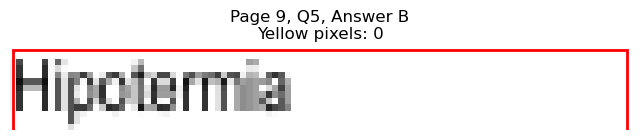

Page 9, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=387.8, y1=367.2
Page 9, Q5, C: Yellow pixels: 111
Page 9, Q5, C: Total non-white pixels: 421
Page 9, Q5, C: Yellow percentage: 26.4%


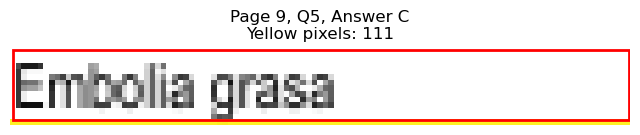

Page 9, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=430.9, y1=379.8
Page 9, Q5, D: Yellow pixels: 1598
Page 9, Q5, D: Total non-white pixels: 2002
Page 9, Q5, D: Yellow percentage: 79.8%


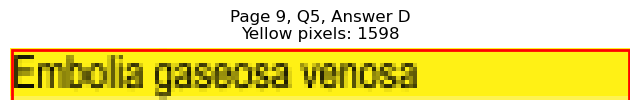


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=120.5, y1=417.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 240
Page 9, Q6, A: Yellow percentage: 0.0%


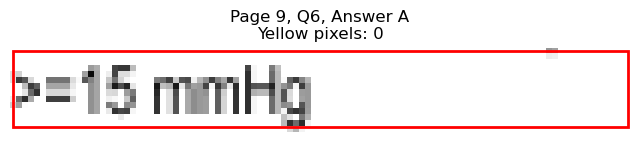

Page 9, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=115.2, y1=430.3
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 215
Page 9, Q6, B: Yellow percentage: 0.0%


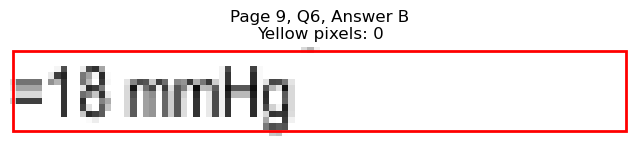

Page 9, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=379.7, y1=417.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 230
Page 9, Q6, C: Yellow percentage: 0.0%


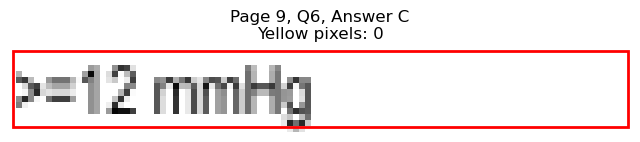

Page 9, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=374.5, y1=430.3
Page 9, Q6, D: Yellow pixels: 1003
Page 9, Q6, D: Total non-white pixels: 1372
Page 9, Q6, D: Yellow percentage: 73.1%


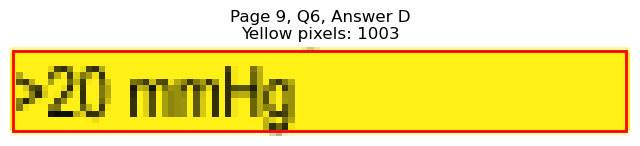


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=149.5, y1=493.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 419
Page 9, Q7, A: Yellow percentage: 0.0%


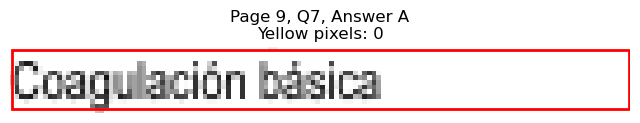

Page 9, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=86.3, y1=506.0
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 89
Page 9, Q7, B: Yellow percentage: 0.0%


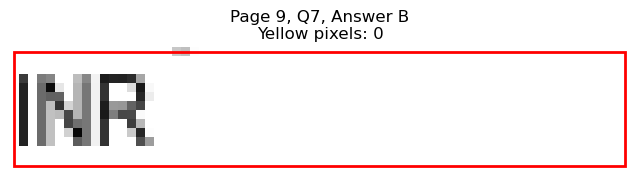

Page 9, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=352.1, y1=493.4
Page 9, Q7, C: Yellow pixels: 76
Page 9, Q7, C: Total non-white pixels: 179
Page 9, Q7, C: Yellow percentage: 42.5%


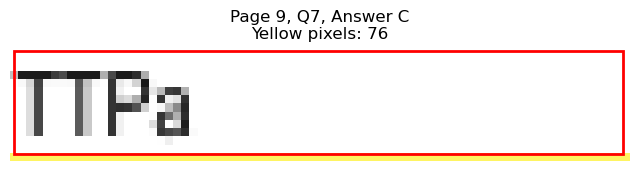

Page 9, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=432.4, y1=506.0
Page 9, Q7, D: Yellow pixels: 1597
Page 9, Q7, D: Total non-white pixels: 2038
Page 9, Q7, D: Yellow percentage: 78.4%


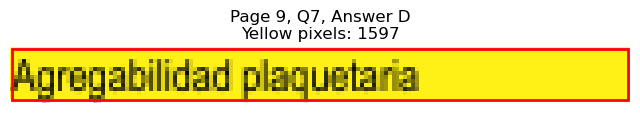


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=182.7, y1=543.8
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 562
Page 9, Q8, A: Yellow percentage: 0.0%


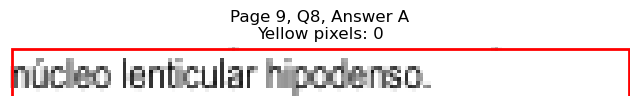

Page 9, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=208.2, y1=556.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 714
Page 9, Q8, B: Yellow percentage: 0.0%


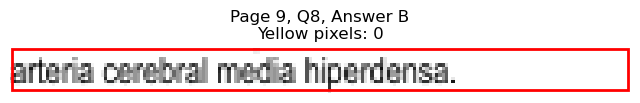

Page 9, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=370.1, y1=543.8
Page 9, Q8, C: Yellow pixels: 1044
Page 9, Q8, C: Total non-white pixels: 1222
Page 9, Q8, C: Yellow percentage: 85.4%


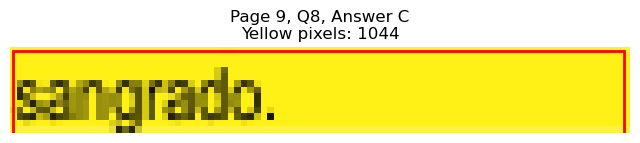

Page 9, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=400.3, y1=556.4
Page 9, Q8, D: Yellow pixels: 120
Page 9, Q8, D: Total non-white pixels: 473
Page 9, Q8, D: Yellow percentage: 25.4%


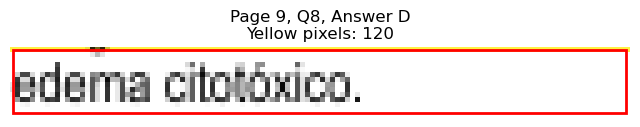


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=96.4, y1=594.4
Page 9, Q9, A: Yellow pixels: 79
Page 9, Q9, A: Total non-white pixels: 230
Page 9, Q9, A: Yellow percentage: 34.3%


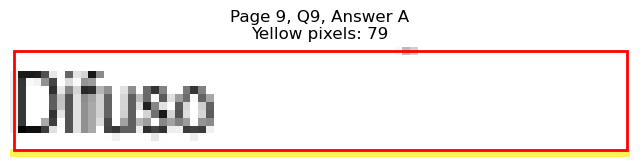

Page 9, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=183.6, y1=607.0
Page 9, Q9, B: Yellow pixels: 1690
Page 9, Q9, B: Total non-white pixels: 2158
Page 9, Q9, B: Yellow percentage: 78.3%


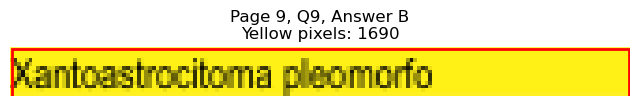

Page 9, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=374.2, y1=594.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 241
Page 9, Q9, C: Yellow percentage: 0.0%


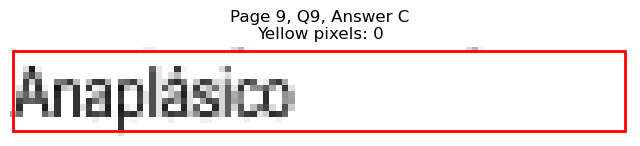

Page 9, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=382.7, y1=607.0
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 272
Page 9, Q9, D: Yellow percentage: 0.0%


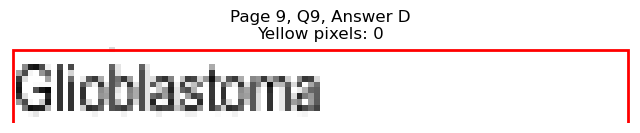


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=241.8, y1=644.9
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 797
Page 9, Q10, A: Yellow percentage: 0.0%


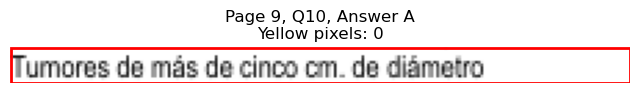

Page 9, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=197.3, y1=657.5
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 651
Page 9, Q10, B: Yellow percentage: 0.0%


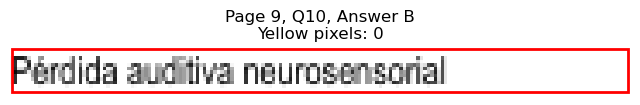

Page 9, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=495.1, y1=644.9
Page 9, Q10, C: Yellow pixels: 2171
Page 9, Q10, C: Total non-white pixels: 2782
Page 9, Q10, C: Yellow percentage: 78.0%


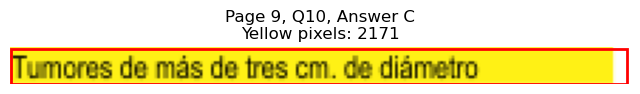

Page 9, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=487.5, y1=657.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 742
Page 9, Q10, D: Yellow percentage: 0.0%


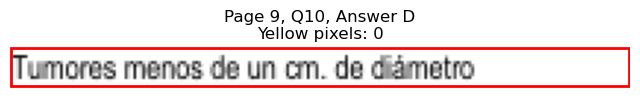


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=145.6, y1=695.3
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 401
Page 9, Q11, A: Yellow percentage: 0.0%


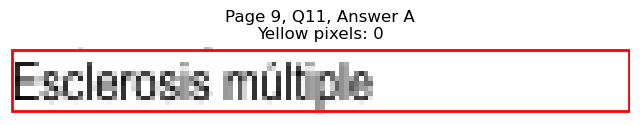

Page 9, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=175.1, y1=708.0
Page 9, Q11, B: Yellow pixels: 1627
Page 9, Q11, B: Total non-white pixels: 2054
Page 9, Q11, B: Yellow percentage: 79.2%


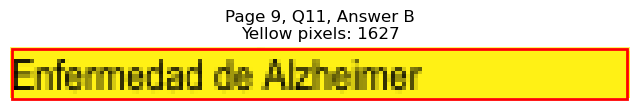

Page 9, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=389.2, y1=695.3
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 308
Page 9, Q11, C: Yellow percentage: 0.0%


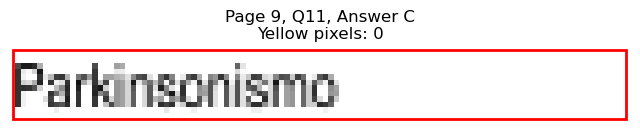

Page 9, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=436.9, y1=708.0
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 586
Page 9, Q11, D: Yellow percentage: 0.0%


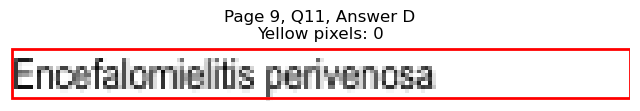


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 2 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=341.1, y1=102.1
Page 10, Q1, A: Yellow pixels: 324
Page 10, Q1, A: Total non-white pixels: 1649
Page 10, Q1, A: Yellow percentage: 19.6%


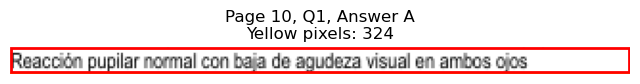

Page 10, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=428.6, y1=114.7
Page 10, Q1, B: Yellow pixels: 4013
Page 10, Q1, B: Total non-white pixels: 5343
Page 10, Q1, B: Yellow percentage: 75.1%


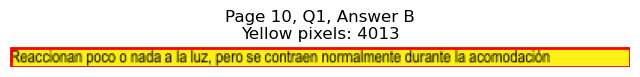

Page 10, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=260.3, y1=127.3
Page 10, Q1, C: Yellow pixels: 243
Page 10, Q1, C: Total non-white pixels: 1175
Page 10, Q1, C: Yellow percentage: 20.7%


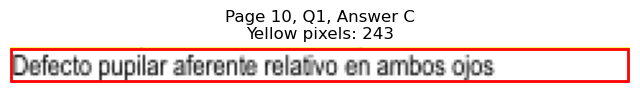

Page 10, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=275.9, y1=139.9
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 1007
Page 10, Q1, D: Yellow percentage: 0.0%


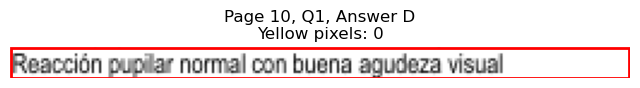


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=271.5, y1=190.4
Page 10, Q2, A: Yellow pixels: 254
Page 10, Q2, A: Total non-white pixels: 1251
Page 10, Q2, A: Yellow percentage: 20.3%


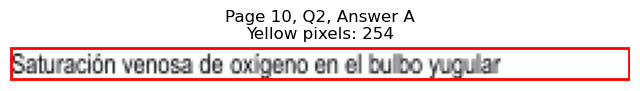

Page 10, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=236.3, y1=203.0
Page 10, Q2, B: Yellow pixels: 2188
Page 10, Q2, B: Total non-white pixels: 2847
Page 10, Q2, B: Yellow percentage: 76.9%


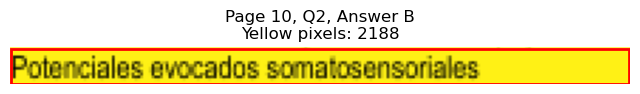

Page 10, Q2 - C: Detected box: x0=68.8, y0=202.9, x1=153.5, y1=215.6
Page 10, Q2, C: Yellow pixels: 136
Page 10, Q2, C: Total non-white pixels: 562
Page 10, Q2, C: Yellow percentage: 24.2%


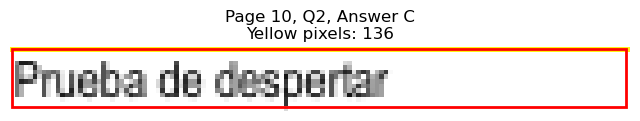

Page 10, Q2 - D: Detected box: x0=68.8, y0=215.7, x1=265.8, y1=228.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 984
Page 10, Q2, D: Yellow percentage: 0.0%


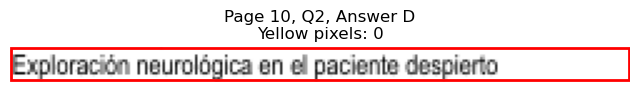


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   El Incremento del tamaño ventrículo laterales ...
1   ¿En qué tipo de meningitis no se altera la glu...
2   En los distritos más alejados de un ámbito san...
3   ¿Cuál es el estudio radiológico de primera lín...
4   Médico informa a su paciente varón de 55 años ...
..                                                ...
95  ¿Cuál de los siguientes astrocitomas tiene una...
96  ¿Cuándo los Schwanoma vestibulares requieren r...
97  ¿Qué patología neuroencefálica se caracteriza ...
98  ¿Cuál es la alteración que se encuentra al exa...
99  En relación al pinzamiento del aneurisma cereb...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                        comunicante.   
1                                         Tuberculosa   
2                                    Confidencialidad   
3                                       RMN perfusión   
4                                     No maleficencia   
..                                                ...   
95                                             Difuso   
96            Tumores de más de cinco cm. de diámetro   
97                                Esclerosis múltiple   
98  Reacción pupilar normal con baja de agudeza vi...   
99   Saturación venosa de oxígeno en el bulbo yugular   

                                             option_B  \
0                                        obstructiva.   
1                                       Piógena aguda   
2                                     No maleficencia   
3                                    TC sin contraste   
4                                           Autonomía   
..                                                ...   
95                         Xantoastrocitoma pleomorfo   
96                    Pérdida auditiva neurosensorial   
97                            Enfermedad de Alzheimer   
98  Reaccionan poco o nada a la luz, pero se contr...   
99             Potenciales evocados somatosensoriales   

                                           option_C  \
0                                          exvacuo.   
1                                       Viral aguda   
2                                         Autonomía   
3                                       Angiografía   
4                                          Justicia   
..                                              ...   
95                                       Anaplásico   
96           Tumores de más de tres cm. de diámetro   
97                                    Parkinsonismo   
98  Defecto pupilar aferente relativo en ambos ojos   
99                              Prueba de despertar   

                                            option_D  
0                                        traumático.  
1                                     Criptococócica  
2                                           Justicia  
3                                     Espectroscopía  
4                                       Beneficencia  
..                                               ...  
95                                      Glioblastoma  
96               Tumores menos de un cm. de diámetro  
97                       Encefalomielitis perivenosa  
98  Reacción pupilar normal con buena agudeza visual  
99  Exploración neurológica en el paciente despierto  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               D
3               B
4               B
..            ...
95              B
96              C
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   El Incremento del tamaño ventrículo laterales ...   
1   ¿En qué tipo de meningitis no se altera la glu...   
2   En los distritos más alejados de un ámbito san...   
3   ¿Cuál es el estudio radiológico de primera lín...   
4   Médico informa a su paciente varón de 55 años ...   
..                                                ...   
95  ¿Cuál de los siguientes astrocitomas tiene una...   
96  ¿Cuándo los Schwanoma vestibulares requieren r...   
97  ¿Qué patología neuroencefálica se caracteriza ...   
98  ¿Cuál es la alteración que se encuentra al exa...   
99  En relación al pinzamiento del aneurisma cereb...   

                                             option_A  \
0                                        comunicante.   
1                                         Tuberculosa   
2                                    Confidencialidad   
3                                       RMN perfusión   
4                                     No maleficencia   
..                                                ...   
95                                             Difuso   
96            Tumores de más de cinco cm. de diámetro   
97                                Esclerosis múltiple   
98  Reacción pupilar normal con baja de agudeza vi...   
99   Saturación venosa de oxígeno en el bulbo yugular   

                                             option_B  \
0                                        obstructiva.   
1                                       Piógena aguda   
2                                     No maleficencia   
3                                    TC sin contraste   
4                                           Autonomía   
..                                                ...   
95                         Xantoastrocitoma pleomorfo   
96                    Pérdida auditiva neurosensorial   
97                            Enfermedad de Alzheimer   
98  Reaccionan poco o nada a la luz, pero se contr...   
99             Potenciales evocados somatosensoriales   

                                           option_C  \
0                                          exvacuo.   
1                                       Viral aguda   
2                                         Autonomía   
3                                       Angiografía   
4                                          Justicia   
..                                              ...   
95                                       Anaplásico   
96           Tumores de más de tres cm. de diámetro   
97                                    Parkinsonismo   
98  Defecto pupilar aferente relativo en ambos ojos   
99                              Prueba de despertar   

                                            option_D correct_answer  
0                                        traumático.              A  
1                                     Criptococócica              C  
2                                           Justicia              D  
3                                     Espectroscopía              B  
4                                       Beneficencia              B  
..                                               ...            ...  
95                                      Glioblastoma              B  
96               Tumores menos de un cm. de diámetro              C  
97                       Encefalomielitis perivenosa              B  
98  Reacción pupilar normal con buena agudeza visual              B  
99  Exploración neurológica en el paciente despierto              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/NEUROCIRUGIA.csv
